This notebook contains the scripts to 
 - classical models method
 - modèle sur mesure avancé ???
 - BERT models method

In [1]:
# Set up logging
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
from utils import *

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import TweetTokenizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('all')

import spacy
from spacy.tokens import Token

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/bartcus/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading packa

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, plot_confusion_matrix

In [4]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [5]:
nlp = spacy.load("en_core_web_sm")

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bartcus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bartcus/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
import re
import string
from unidecode import unidecode
import os
from pandarallel import pandarallel
from tqdm import tqdm

In [7]:
handle_regex = r"@[\w\d_]+"
like_handle = lambda token: re.fullmatch(handle_regex, token.text)
Token.set_extension("like_handle", getter=like_handle)

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential


from keras.models import load_model
from keras.layers import Input, TextVectorization, Dense, Dropout, Activation, Embedding, Flatten, SimpleRNN, MaxPooling1D
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC

First we imort the data and analyse it as it is. This is followed by some data preprocessing, here text preprocessing by using nltk and spacy packages.

# Data importing and preprocessing

In [9]:
data = pd.read_csv("data/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1',
            header=None, usecols = [0, 5], names=['Target', 'Text'])
data = reduce_dataframe_memory_usage(data)
data.head()

Memory usage of dataframe is 24.41 MB
Memory usage after optimization is 15.26 MB
Decreased by 37 %%


Target                                               Text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....

In [10]:
data.Target.unique()

<IntegerArray>
[0, 4]
Length: 2, dtype: Int8

In [96]:
data.shape

(1600000, 2)

In [97]:
data.nunique()

Target          2
Text      1581466
dtype: int64

In [98]:
data['Target'] = data['Target'].apply(lambda x: 1 if(x==4) else 0)

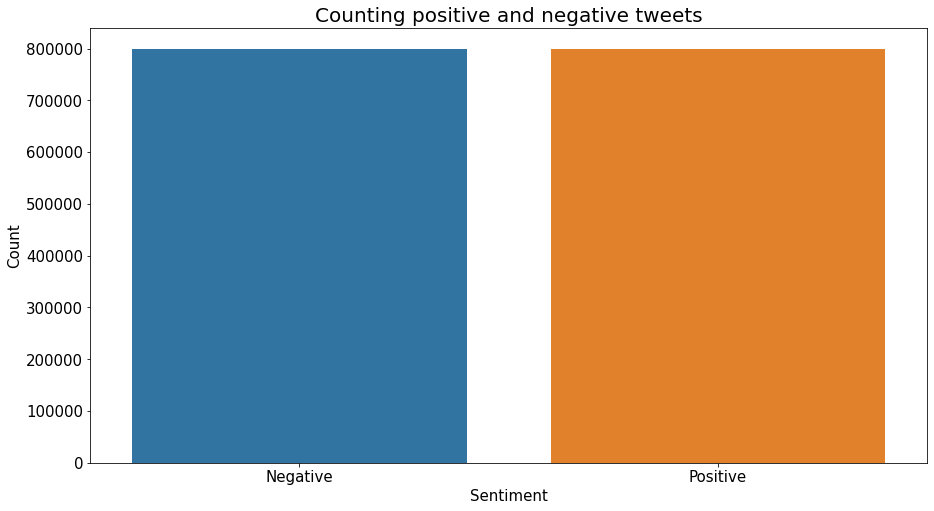

In [99]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='Target', data=data)
plt.title('Counting positive and negative tweets', fontsize=20);
plt.ylabel('Count', fontsize=15);
plt.xlabel('Sentiment', fontsize=15);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
ax.set_xticklabels(['Negative', 'Positive']);

In [100]:
data[data['Target'] == 0].head()

Target                                               Text
0       0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1       0  is upset that he can't update his Facebook by ...
2       0  @Kenichan I dived many times for the ball. Man...
3       0    my whole body feels itchy and like its on fire 
4       0  @nationwideclass no, it's not behaving at all....

In [101]:
data[data['Target'] == 1].head()

Target                                               Text
800000       1       I LOVE @Health4UandPets u guys r the best!! 
800001       1  im meeting up with one of my besties tonight! ...
800002       1  @DaRealSunisaKim Thanks for the Twitter add, S...
800003       1  Being sick can be really cheap when it hurts t...
800004       1    @LovesBrooklyn2 he has that effect on everyone

Sampling the data to take 10000 with positive and negative tweets

In [102]:
data = pd.concat([data[data['Target']==0].iloc[:10000], data[data['Target']==1].iloc[-10000:]])
data = data.reset_index(drop=True)

In [103]:
data

Target                                               Text
0           0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1           0  is upset that he can't update his Facebook by ...
2           0  @Kenichan I dived many times for the ball. Man...
3           0    my whole body feels itchy and like its on fire 
4           0  @nationwideclass no, it's not behaving at all....
...       ...                                                ...
19995       1  Just woke up. Having no school is the best fee...
19996       1  TheWDB.com - Very cool to hear old Walt interv...
19997       1  Are you ready for your MoJo Makeover? Ask me f...
19998       1  Happy 38th Birthday to my boo of alll time!!! ...
19999       1  happy #charitytuesday @theNSPCC @SparksCharity...

[20000 rows x 2 columns]

***Tokenization with spacy***

In [104]:
# Définition de la fonction de nettoyage

def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't",
                 "doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx':
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token

def clean(text) :
    doc = nlp(text)
    
    tokens = [
        cleaned(unidecode(token.lemma_.lower())) for token in doc 
        if (not token.is_punct
        and not token.is_currency
        and not token.is_space
        and not token.is_stop
        and not token.like_email
        and not token.like_url 
        and not token.like_num
        #and not token.is_oov #out of vocabulary
        and len(token) > 1 
        and not token.ent_type_ == "PERSON" 
        and not token.ent_type_ == "ORG" 
        and not token._.like_handle)
    ]

    #Stemming
    st = PorterStemmer()
    tokens = [st.stem(tk) for tk in tokens] 
    
    return ' '.join(tokens)

def clean_1_ch(text) :
    doc = nlp(text)
    
    tokens = [
        token for token in doc 
        if (len(token) > 1)
    ]
    
    return ' '.join(map(str, tokens))

In [105]:
def cleaning_links(text):
    return re.sub(r'(https|http|)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)

def cleaning_email(text):
    # cleaning email and mentions
    return re.sub("(@[A-Za-z0-9_]+)","", text)

def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

#removing emojis from string
def de_emojify(text):
    regex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F" 
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
                           "]+", flags = re.UNICODE)
    return regex_pattern.sub(r'', text)

def cleaning_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def all_cleaning(text):
    text = cleaning_links(text)
    text = cleaning_email(text)
    text = de_emojify(text)
    text = cleaning_numbers(text)
    text = cleaning_punctuations(text)
    return text

In [114]:
data = data[data.CleanText!='']

In [115]:
%%time
if os.path.exists("data/processed/processed_nlp_data.pkl.gz"):
    logger.info(">>> Loading cleaned and preprocessed data...")
    data = pd.read_pickle("data/processed/processed_nlp_data.pkl.gz")
    logger.info(f">>> OK : {len(data)} data loaded from pickle file.")
else:
    logger.info(">>> Data cleaning and preprocessing...")
    pandarallel.initialize()
    data['CleanTextSpacy'] = data.Text.parallel_apply(lambda x: clean(x))
    data['CleanText']= data.CleanTextSpacy.apply(lambda x: all_cleaning(x))
    data['CleanText']= data.CleanText.parallel_apply(lambda x: clean_1_ch(x))
    data.to_pickle("data/processed/processed_nlp_data.pkl.gz")

INFO:__main__:>>> Data cleaning and preprocessing...


INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: user 445 ms, sys: 205 ms, total: 649 ms
Wall time: 17.2 s


In [116]:
data = data.drop(['CleanTextSpacy', 'Text'], axis=1)
data.head()

Target                                          CleanText
0       0                        awww bummer shoulda get day
1       0  upset updat facebook text cri result school to...
2       0               dive time ball manag save rest bound
3       0                          bodi feel itchi like fire
4       0                                          behav mad

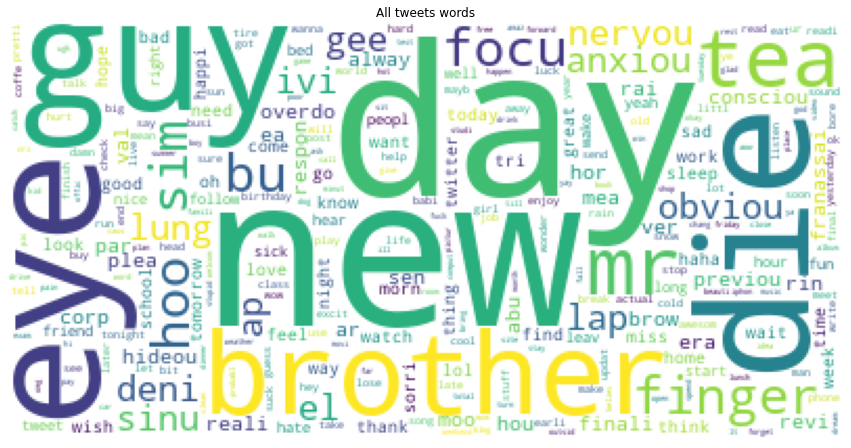

In [117]:
word_count_all = pd.DataFrame(pd.DataFrame(data).CleanText.str.split(expand=True).stack().value_counts())
word_count_all = word_count_all.reset_index()
word_count_all.columns=['word', 'count']
plot_words(word_count_all, col='word', height = 15, wieght = 10, max_words = 1000, titl='All tweets words')

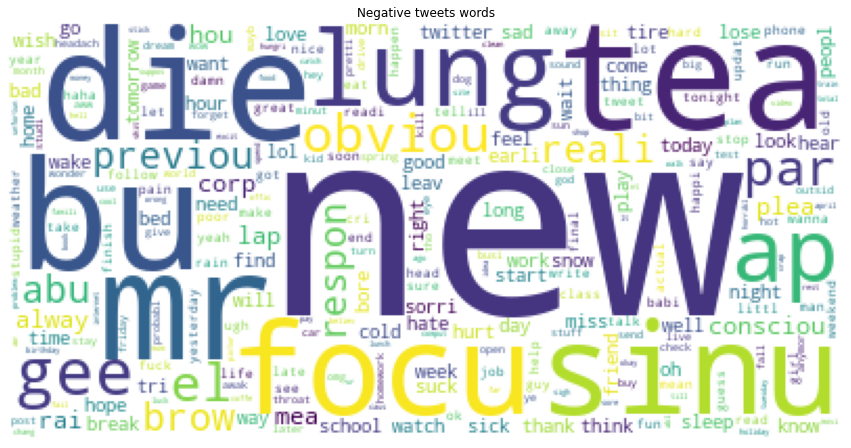

In [118]:
word_count_bad = pd.DataFrame(pd.DataFrame(data.head(10000)).CleanText.str.split(expand=True).stack().value_counts())
word_count_bad = word_count_bad.reset_index()
word_count_bad.columns=['word', 'count']
plot_words(word_count_bad, col='word', height = 15, wieght = 10, max_words = 1000, titl='Negative tweets words')

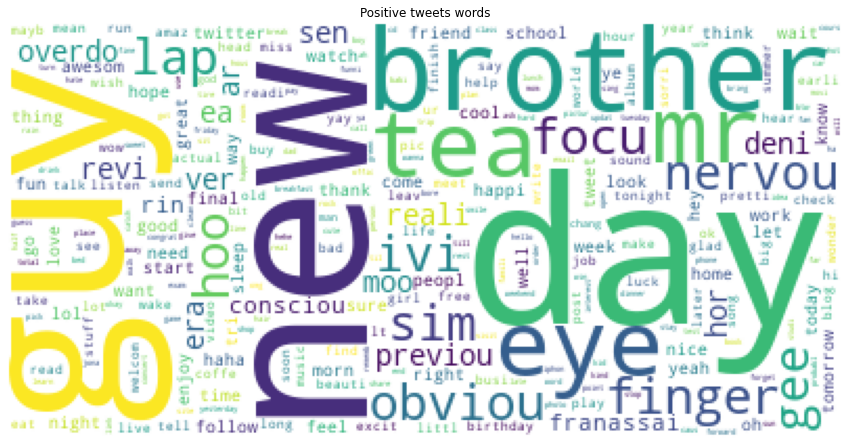

In [119]:
word_count_good = pd.DataFrame(pd.DataFrame(data.tail(10000)).CleanText.str.split(expand=True).stack().value_counts())
word_count_good = word_count_good.reset_index()
word_count_good.columns=['word', 'count']
plot_words(word_count_good, col='word', height = 15, wieght = 10, max_words = 1000, titl='Positive tweets words')

# Data vectorization

## Vectorizing the dataset using TfidfVectorizer

In [41]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data' + pkl_extension
vocabulary_file_path = vectorized_dataset_path + 'vocabulary_data' + pkl_extension
                
if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)

if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)
        
with timer("Data vectorization with Tfidf"):
    if os.path.exists(vectorized_dataset_file_path):
        logger.info(">>> Loading Tfidf Vectorized data...")
        
        # Load vectorized dataset
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
        # Load vocabulary
        with (open(vocabulary_file_path, "rb")) as f:
            vocabulary = pickle.load(f)
    else:
        logger.info(">>> Creating Tfidf Vectorized data...")
        vect = TfidfVectorizer()
        X = vect.fit_transform(data.CleanText)
        vocabulary = vect.get_feature_names_out()
        
        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)

        # Save vocabulary as pickle
        with open(vocabulary_file_path, "wb") as f:
            pickle.dump(vocabulary, f)

INFO:__main__:>>> Creating Tfidf Vectorized data...


Data vectorization with Tfidf - done in 0s


## Vectorize with spacy

In [42]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_spacy' + pkl_extension

if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)

if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)
        
with timer("Data vectorization with Spacy"): 
    if os.path.exists(vectorized_dataset_file_path):
        logger.info(">>> Loading Spacy Vectorized data...")
        
        # Load vectorized dataset
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
    else:
        logger.info(">>> Creating Spacy Vectorized data...")
        # Encode text
        X = [nlp(doc).vector for doc in tqdm(data.CleanText)]
        X = np.vstack(X)
        
        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)

INFO:__main__:>>> Creating Spacy Vectorized data...
100%|████████████████████████████████████| 19773/19773 [00:48<00:00, 410.72it/s]

Data vectorization with Spacy - done in 48s


## Vectorizing the dataset using Doc2Vec

In [43]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec

pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_doc2vec' + pkl_extension

if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)
    
if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)

with timer("Data vectorization with Doc2Vec"):
    if os.path.exists(vectorized_dataset_file_path):  
        logger.info(">>> Loading Doc2Vec Vectorized data...")
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
    else:
        logger.info(">>> Creating Doc2Vec Vectorized data...")
        documents = [text.split() for text in data.CleanText]
        # Tag documents for training
        X = [TaggedDocument(doc, [i]) for i, doc in enumerate(documents)]

        # Train doc2vec model
        doc2vec = Doc2Vec()
        doc2vec.build_vocab(X)
        doc2vec.train(X, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

        # Vectorize text
        X = [doc2vec.infer_vector(doc.words) for doc in X]
        X = np.vstack(X)

        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)

INFO:__main__:>>> Creating Doc2Vec Vectorized data...
INFO:gensim.utils:Doc2Vec lifecycle event {'params': 'Doc2Vec<dm/m,d100,n5,w5,mc5,s0.001,t3>', 'datetime': '2022-09-15T14:31:32.911112', 'gensim': '4.2.0', 'python': '3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) \n[Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-arm-64bit', 'event': 'created'}
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0 words/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:PROGRESS: at example #10000, processed 58865 words (6623347 words/s), 8988 word types, 0 tags
INFO:gensim.models.doc2vec:collected 14138 word types and 19773 unique tags from a corpus of 19773 examples and 113718 words
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Doc2Vec lifecycle event {'msg': 'effective_min_count=5 retains 2638 unique words (18.66% of original 14138, drops 11500)', 'datetime': '2022-09

Data vectorization with Doc2Vec - done in 6s


## Vectorizing using Glove

In [44]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove.6B.zip

In [45]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_glove' + pkl_extension
embedding_matrix_file_path = vectorized_dataset_path + 'embedding_matrix_glove' + pkl_extension

if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)
    
if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)
    
with timer("Data vectorization with Glove"):
    if os.path.exists(vectorized_dataset_file_path):  
        logger.info(">>> Loading Glove Vectorized data...")
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
        with (open(embedding_matrix_file_path, "rb")) as f:
            embedding_matrix = pickle.load(f)
    else:
        v_size = 100
        logger.info(">>> Creating Glove Vectorized data...")
        
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(data.CleanText)

        word_index = tokenizer.word_index
        vocab_size = len(tokenizer.word_index) + 1
        print("Vocabulary Size :", vocab_size)
        
        X = pad_sequences(tokenizer.texts_to_sequences(data.CleanText),
                        maxlen = v_size)
        
        
        LR = 1e-3
        BATCH_SIZE = 1024
        EPOCHS = 10
        
        embeddings_index = {}

        f = open('glove.6B.100d.txt')
        for line in f:
            values = line.split()
            word = value = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()

        print('Found %s word vectors.' %len(embeddings_index))
        
        embedding_matrix = np.zeros((vocab_size, v_size))
        for word, i in word_index.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
                
        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)
            
        # Save vocabulary as pickle
        with open(embedding_matrix_file_path, "wb") as f:
            pickle.dump(embedding_matrix, f)

INFO:__main__:>>> Creating Glove Vectorized data...


Vocabulary Size : 14139
Found 400000 word vectors.
Data vectorization with Glove - done in 4s


## Vectorizing with Word2Vec

In [46]:
import gensim
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_w2v' + pkl_extension
embedding_matrix_file_path = vectorized_dataset_path + 'embedding_matrix_w2v' + pkl_extension

if (not os.path.exists('data/processed/')):
    os.makedirs("data/processed/", exist_ok=True)
    
if (not os.path.exists(vectorized_dataset_path)):
    os.makedirs(vectorized_dataset_path, exist_ok=True)

with timer("Data vectorization with Word2Vec"):
    if os.path.exists(vectorized_dataset_file_path):  
        logger.info(">>> Loading Word2Vec Vectorized data...")
        with (open(vectorized_dataset_file_path, "rb")) as f:
            X = pickle.load(f)
    else:
        v_size = 100
        logger.info(">>> Creating Word2Vec Vectorized data...")
        
        documents = [text.split() for text in data.CleanText]
        
        w2v_model = gensim.models.word2vec.Word2Vec(vector_size=v_size, 
                                            window=7, 
                                            min_count=10, 
                                            workers=8)
        w2v_model.build_vocab(documents)
        words = list(w2v_model.wv.index_to_key) 
        vocab_size = len(words)
        print("Vocab size", vocab_size)
        
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(data.CleanText)

        word_index = tokenizer.word_index
        vocab_size = len(tokenizer.word_index) + 1
        print("Vocabulary Size :", vocab_size)
        
        X = pad_sequences(tokenizer.texts_to_sequences(data.CleanText), maxlen=v_size)
        print("X Size :", X.shape)
        
        embedding_matrix = np.zeros((vocab_size, v_size))
        for word, i in tokenizer.word_index.items():
            if word in w2v_model.wv:
                embedding_matrix[i] = w2v_model.wv[word]
        print("embedding_matrix Size :", embedding_matrix.shape)
        
        # Save vectorized dataset as pickle
        with open(vectorized_dataset_file_path, "wb") as f:
            pickle.dump(X, f)
            
        # Save vocabulary as pickle
        with open(embedding_matrix_file_path, "wb") as f:
            pickle.dump(embedding_matrix, f)

INFO:__main__:>>> Creating Word2Vec Vectorized data...
INFO:gensim.utils:Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=100, alpha=0.025>', 'datetime': '2022-09-15T14:32:06.795870', 'gensim': '4.2.0', 'python': '3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) \n[Clang 13.0.1 ]', 'platform': 'macOS-12.4-arm64-arm-64bit', 'event': 'created'}
INFO:gensim.models.word2vec:collecting all words and their counts
INFO:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 58865 words, keeping 8988 word types
INFO:gensim.models.word2vec:collected 14138 word types from a corpus of 113718 raw words and 19773 sentences
INFO:gensim.models.word2vec:Creating a fresh vocabulary
INFO:gensim.utils:Word2Vec lifecycle event {'msg': 'effective_min_count=10 retains 1532 unique words (10.84% of original 14138, drops 12606)', 'datetime': '2022-09-15T14:32:06.820461', 'gensi

Vocab size 1532
Vocabulary Size : 14139
X Size : (19773, 100)
embedding_matrix Size : (14139, 100)
Data vectorization with Word2Vec - done in 0s


# Loading vectorized and preprocessed data

In [9]:
if os.path.exists("data/processed/processed_nlp_data.pkl.gz"):
    logger.info(">>> Loading cleaned and preprocessed data...")
    data = pd.read_pickle("data/processed/processed_nlp_data.pkl.gz")
    logger.info(f">>> OK : {len(data)} data loaded from pickle file.")

INFO:__main__:>>> Loading cleaned and preprocessed data...
INFO:__main__:>>> OK : 19773 data loaded from pickle file.


In [10]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data' + pkl_extension
vocabulary_file_path = vectorized_dataset_path + 'vocabulary_data' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Tfidf Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X = pickle.load(f)
    # Load vocabulary
    with (open(vocabulary_file_path, "rb")) as f:
        vocabulary = pickle.load(f)
else:
    logger.info(">>> Please create Tfidf Vectorized data...")

INFO:__main__:>>> Loading Tfidf Vectorized data...


In [11]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_doc2vec' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Word2Vec Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_d2v = pickle.load(f)
else:
    logger.info(">>> Please create Word2Vec Vectorized data...")

INFO:__main__:>>> Loading Word2Vec Vectorized data...


In [12]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_spacy' + pkl_extension
vocabulary_file_path = vectorized_dataset_path + 'vocabulary_data_spacy' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Spacy Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_spacy = pickle.load(f)
else:
    logger.info(">>> Please create Spacy Vectorized data...")

INFO:__main__:>>> Loading Spacy Vectorized data...


In [13]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_w2v' + pkl_extension
embedding_file_path = vectorized_dataset_path + 'embedding_matrix_w2v' + pkl_extension


if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading W2V Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_w2v = pickle.load(f)
        
    # Load embedding matrix
    with (open(embedding_file_path, "rb")) as f:
        embedding_matrix_w2v = pickle.load(f)
else:
    logger.info(">>> Please create W2V Vectorized data...")

INFO:__main__:>>> Loading W2V Vectorized data...


In [14]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_glove' + pkl_extension
embedding_file_path = vectorized_dataset_path + 'embedding_matrix_glove' + pkl_extension


if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Glove Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_glove = pickle.load(f)
        
    # Load embedding matrix
    with (open(embedding_file_path, "rb")) as f:
        embedding_matrix_glove = pickle.load(f)
else:
    logger.info(">>> Please create W2V Vectorized data...")

INFO:__main__:>>> Loading Glove Vectorized data...


In [54]:
X_w2v.shape

(19773, 100)

In [56]:
embedding_matrix_w2v.shape

(14139, 100)

In [58]:
X_glove.shape

(19773, 100)

In [59]:
embedding_matrix_glove.shape

(14139, 100)

# Modeling

## Helpping functions

In [63]:
def plot_roc_curve(clf, X_test, y_test, y_pred, model_title):
    if hasattr(clf, "predict_proba"):
        y_pred_proba = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_pred_proba = clf.decision_function(X_test)
    else:
        y_pred_proba = y_pred
        
    # performing the roc curve calculations
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    # Plotting the ROC Curve
    plt.figure(figsize=(10,10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='LR')
    plt.xlabel('False Positive Rate', size=15)
    plt.ylabel('True Positive Rate', size=15)
    plt.title('{0} ROC curve'.format(model_title), size=20)
    plt.show()
    
def classification_result(X_train, y_train, X_test, y_test, ml_cl = LogisticRegression(), model_title = 'Logistic Regression', result = {}):
    #LR = LogisticRegression()
    clf = ml_cl.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    print(classification_report(y_test, y_pred))
    accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
    plot_roc_curve(clf, X_test, y_test, y_pred, model_title)
    
    if model_title not in result:
        result[model_title] = {}
        result[model_title]['precision'] = precision
        result[model_title]['recall'] = recall
        result[model_title]['f1_score'] = f1_score
        result[model_title]['accuracy'] = accuracy
    return result

## Classical approach

### Splitting dataset

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, data.Target, train_size = 0.8, random_state = 1)
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(X_d2v, data.Target, train_size = 0.8, random_state = 1)
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_spacy, data.Target, train_size = 0.8, random_state = 1)
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, data.Target, train_size = 0.8, random_state = 1)

In [65]:
result = {}

### SVC

              precision    recall  f1-score   support

           0       0.75      0.68      0.71      2042
           1       0.69      0.76      0.72      1913

    accuracy                           0.72      3955
   macro avg       0.72      0.72      0.72      3955
weighted avg       0.72      0.72      0.72      3955



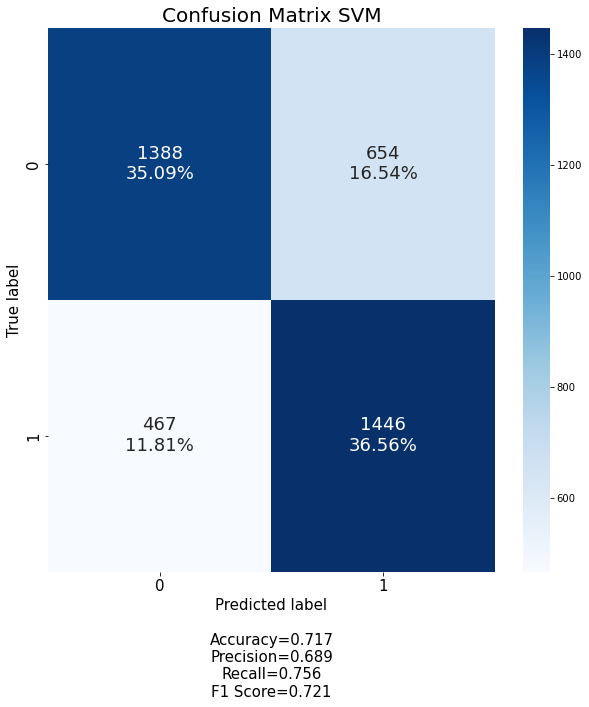

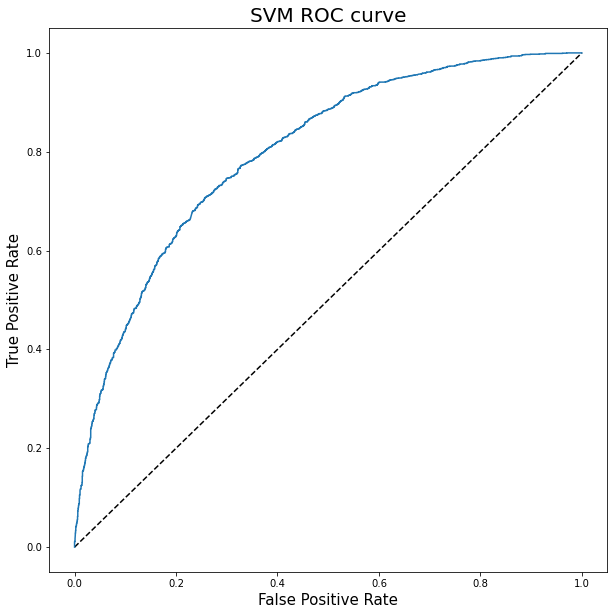

In [66]:
result = classification_result(X_train, y_train, X_test, y_test, ml_cl = LinearSVC(), model_title = 'SVM', result = result)

              precision    recall  f1-score   support

           0       0.65      0.64      0.65      2042
           1       0.62      0.63      0.63      1913

    accuracy                           0.64      3955
   macro avg       0.64      0.64      0.64      3955
weighted avg       0.64      0.64      0.64      3955



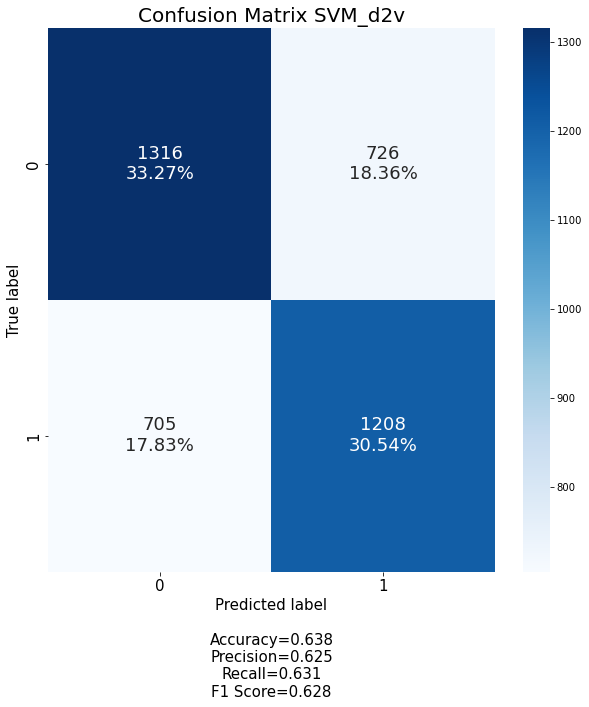

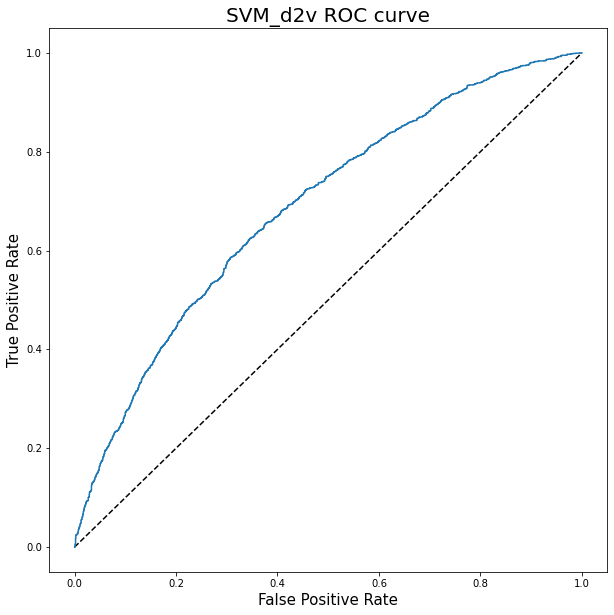

In [69]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, ml_cl = LinearSVC(), model_title = 'SVM_d2v', result = result)

              precision    recall  f1-score   support

           0       0.53      0.58      0.56      2042
           1       0.50      0.45      0.48      1913

    accuracy                           0.52      3955
   macro avg       0.52      0.52      0.52      3955
weighted avg       0.52      0.52      0.52      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


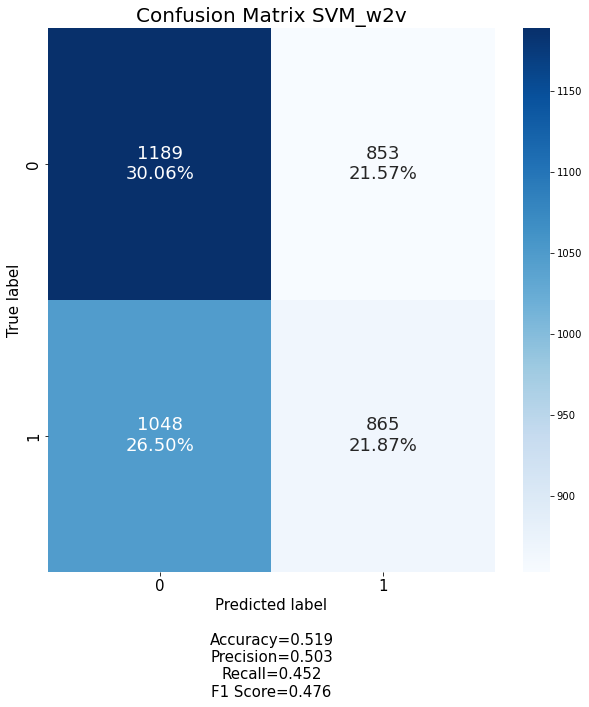

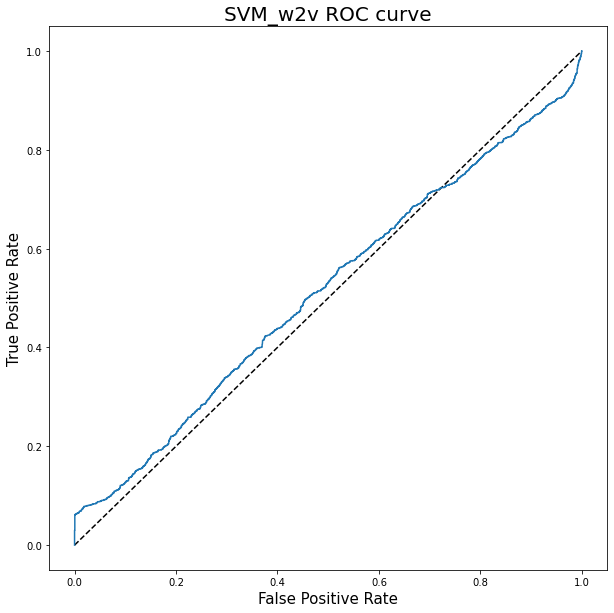

In [68]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, ml_cl = LinearSVC(), model_title = 'SVM_w2v', result = result)

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2042
           1       0.60      0.62      0.61      1913

    accuracy                           0.62      3955
   macro avg       0.62      0.62      0.62      3955
weighted avg       0.62      0.62      0.62      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


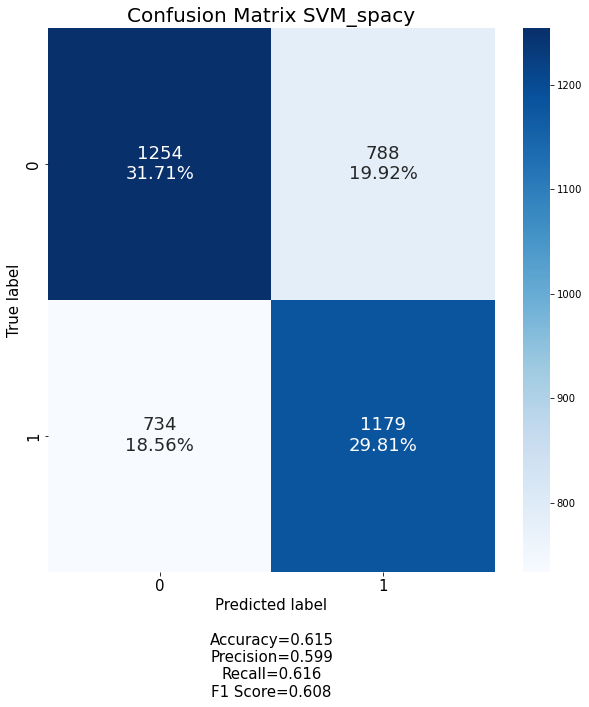

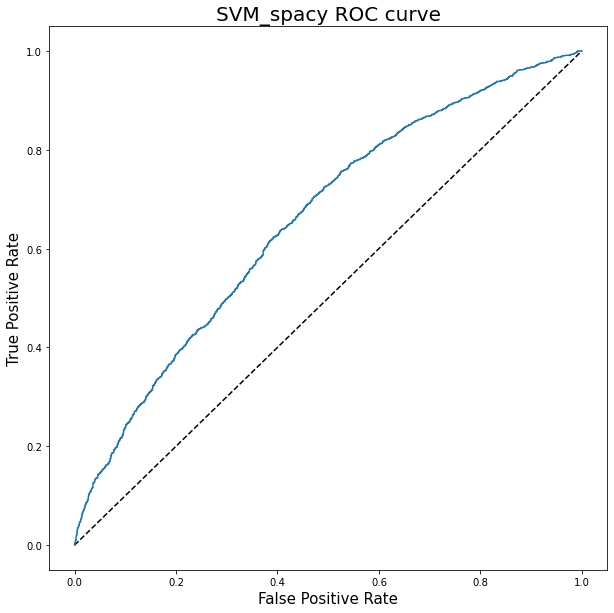

In [70]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, ml_cl = LinearSVC(), model_title = 'SVM_spacy', result = result)

              precision    recall  f1-score   support

           0       0.54      0.21      0.30      2042
           1       0.49      0.81      0.61      1913

    accuracy                           0.50      3955
   macro avg       0.51      0.51      0.45      3955
weighted avg       0.51      0.50      0.45      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


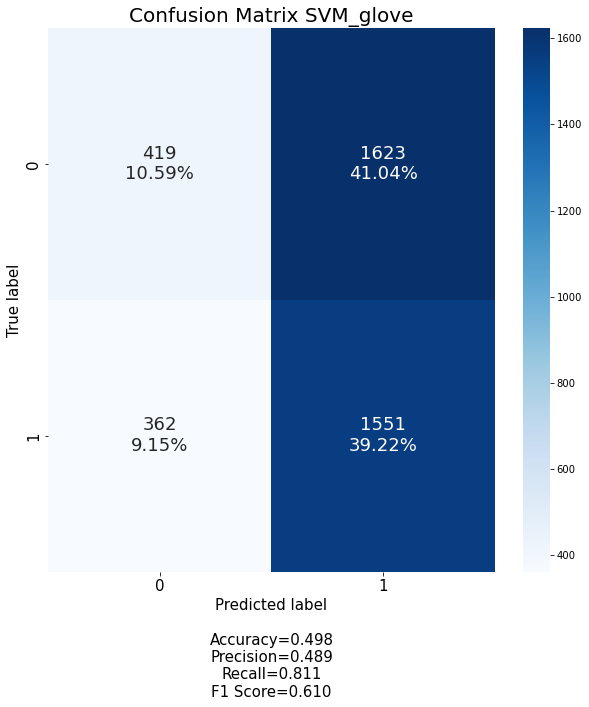

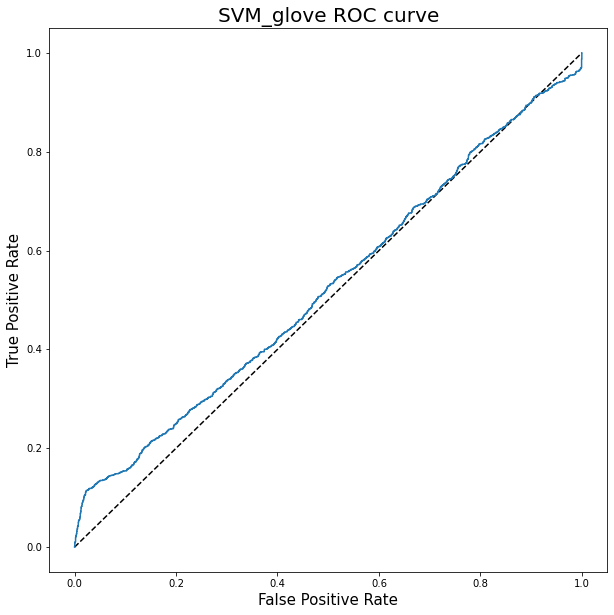

In [71]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, ml_cl = LinearSVC(), model_title = 'SVM_glove', result = result)

### Logistic Regression

              precision    recall  f1-score   support

           0       0.77      0.70      0.73      2042
           1       0.70      0.77      0.74      1913

    accuracy                           0.73      3955
   macro avg       0.74      0.73      0.73      3955
weighted avg       0.74      0.73      0.73      3955



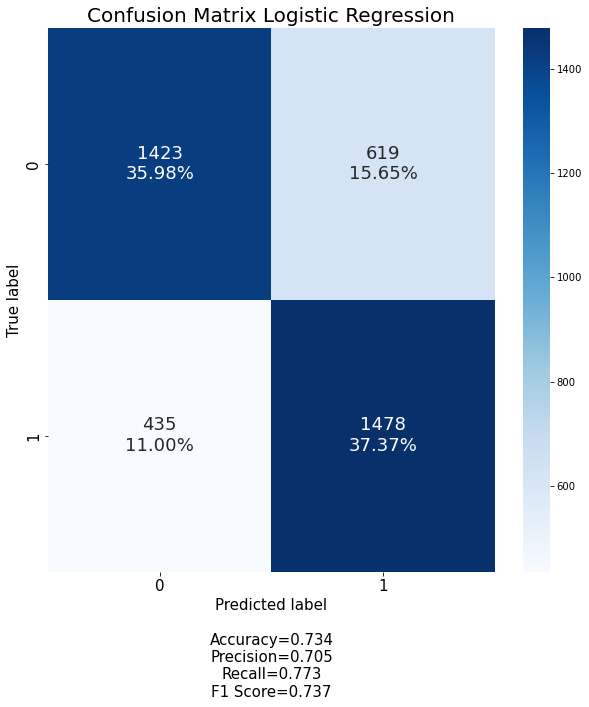

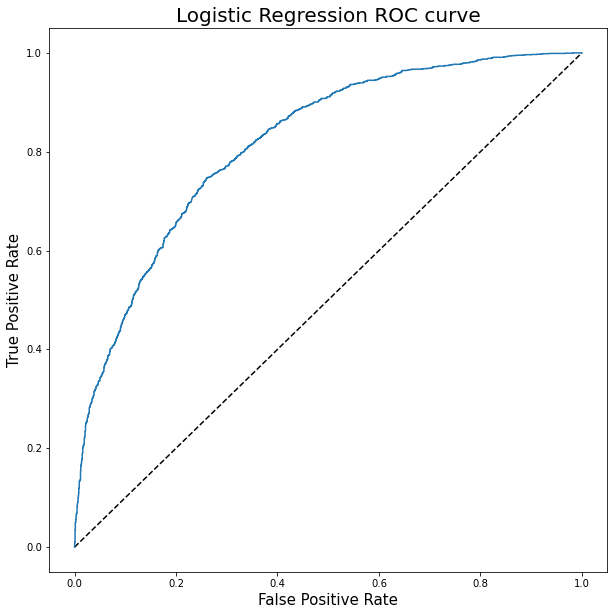

In [72]:
result = classification_result(X_train, y_train, X_test, y_test, LogisticRegression(), model_title = 'Logistic Regression', result = result)

              precision    recall  f1-score   support

           0       0.50      0.04      0.07      2042
           1       0.48      0.96      0.64      1913

    accuracy                           0.48      3955
   macro avg       0.49      0.50      0.36      3955
weighted avg       0.49      0.48      0.35      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


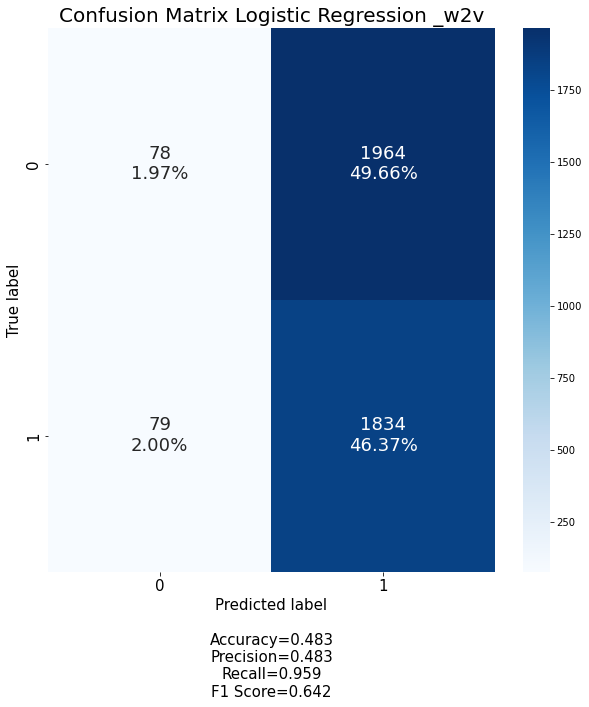

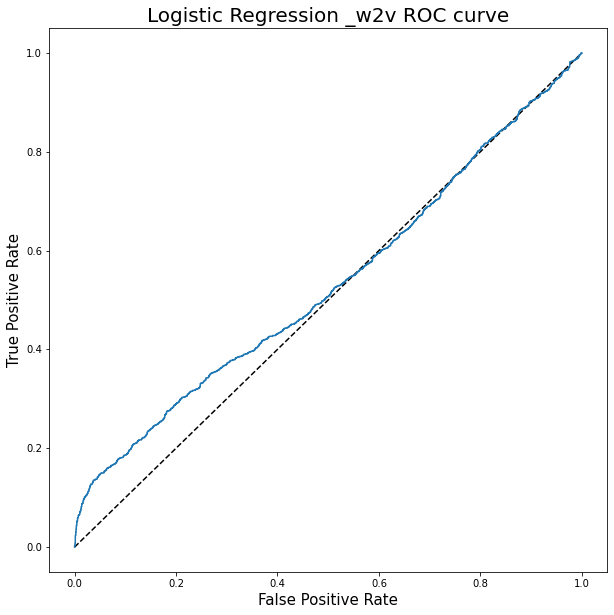

In [73]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, LogisticRegression(), model_title = 'Logistic Regression _w2v', result = result)

              precision    recall  f1-score   support

           0       0.64      0.58      0.61      2042
           1       0.59      0.65      0.62      1913

    accuracy                           0.62      3955
   macro avg       0.62      0.62      0.62      3955
weighted avg       0.62      0.62      0.62      3955



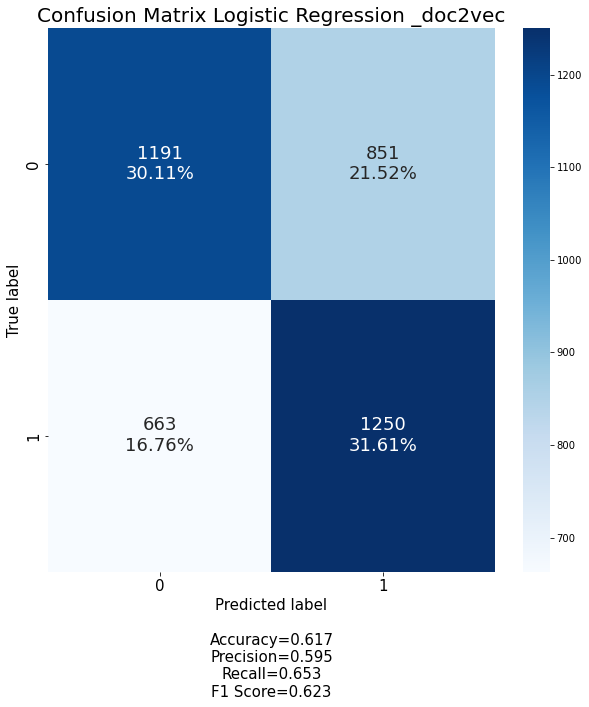

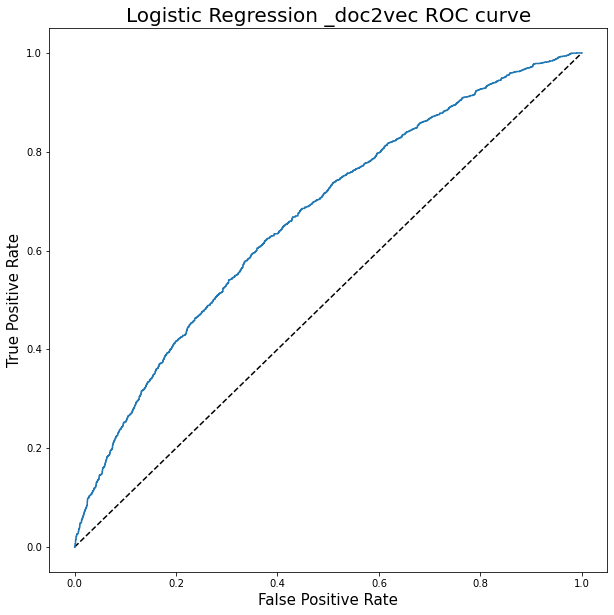

In [74]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, LogisticRegression(), model_title = 'Logistic Regression _doc2vec', result = result)

              precision    recall  f1-score   support

           0       0.50      0.04      0.07      2042
           1       0.48      0.96      0.64      1913

    accuracy                           0.48      3955
   macro avg       0.49      0.50      0.36      3955
weighted avg       0.49      0.48      0.35      3955



/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


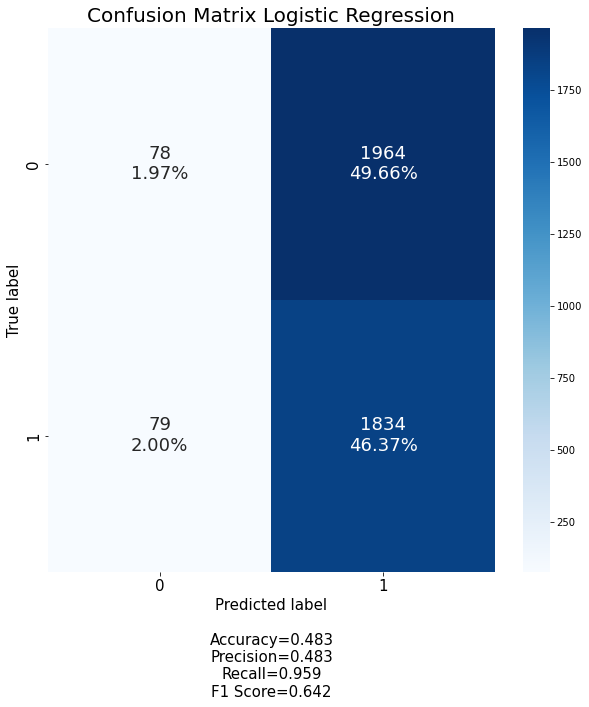

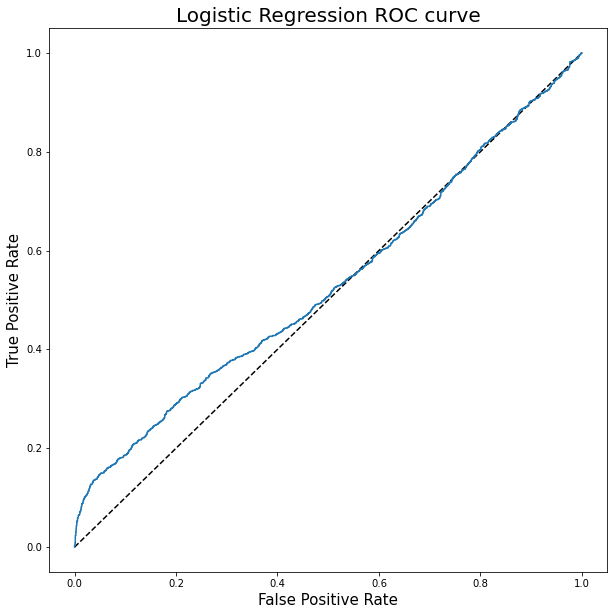

In [75]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, LogisticRegression(), model_title = 'Logistic Regression', result = result)

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2042
           1       0.60      0.62      0.61      1913

    accuracy                           0.61      3955
   macro avg       0.61      0.61      0.61      3955
weighted avg       0.61      0.61      0.61      3955



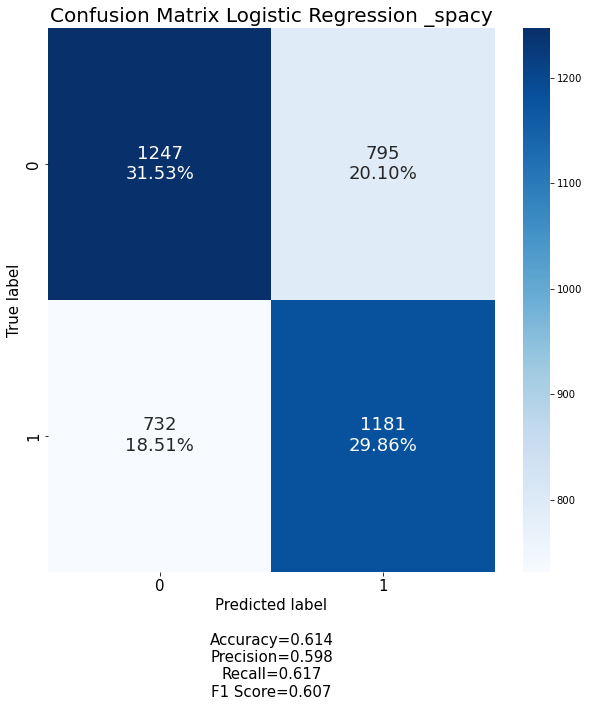

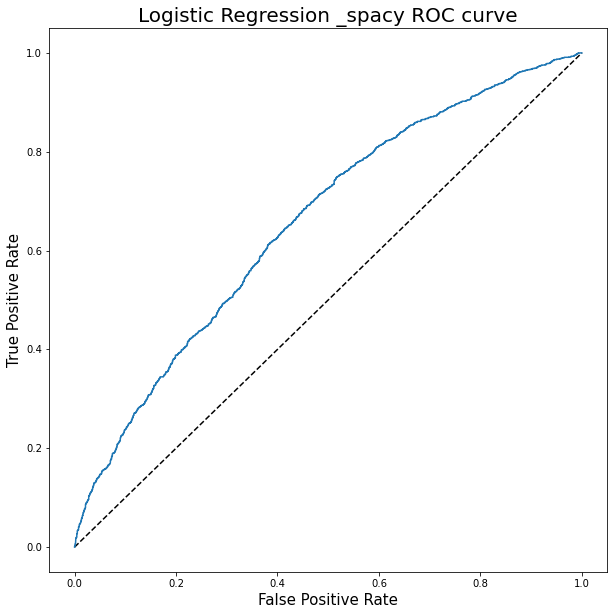

In [76]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, LogisticRegression(), model_title = 'Logistic Regression _spacy', result = result)

### BernoulliNB

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      2042
           1       0.71      0.74      0.72      1913

    accuracy                           0.73      3955
   macro avg       0.73      0.73      0.73      3955
weighted avg       0.73      0.73      0.73      3955



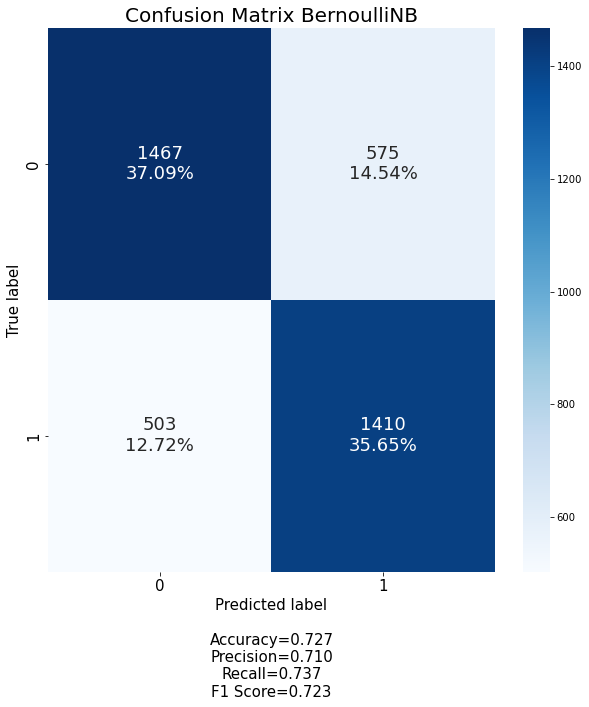

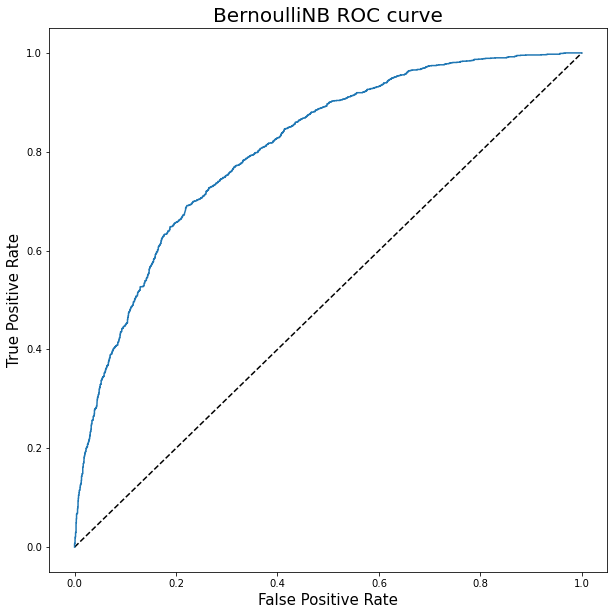

In [77]:
result = classification_result(X_train, y_train, X_test, y_test, BernoulliNB(), model_title = 'BernoulliNB', result = result)

              precision    recall  f1-score   support

           0       0.54      0.51      0.52      2042
           1       0.51      0.54      0.52      1913

    accuracy                           0.52      3955
   macro avg       0.52      0.52      0.52      3955
weighted avg       0.53      0.52      0.52      3955



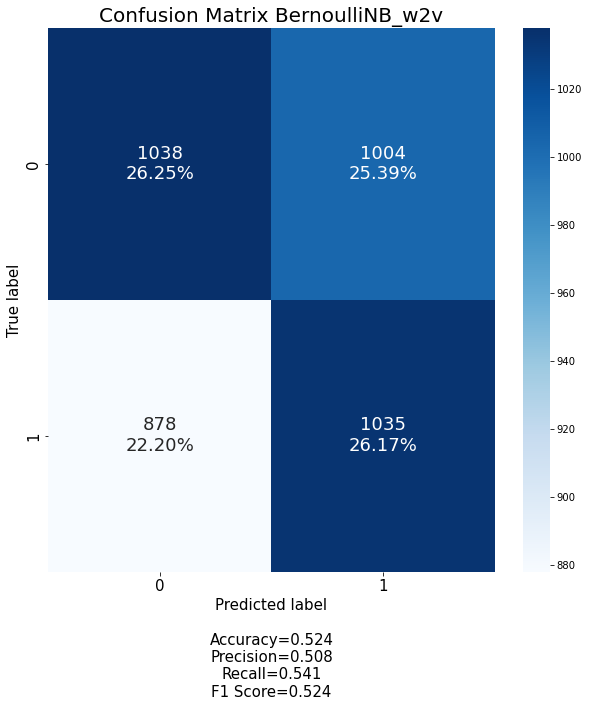

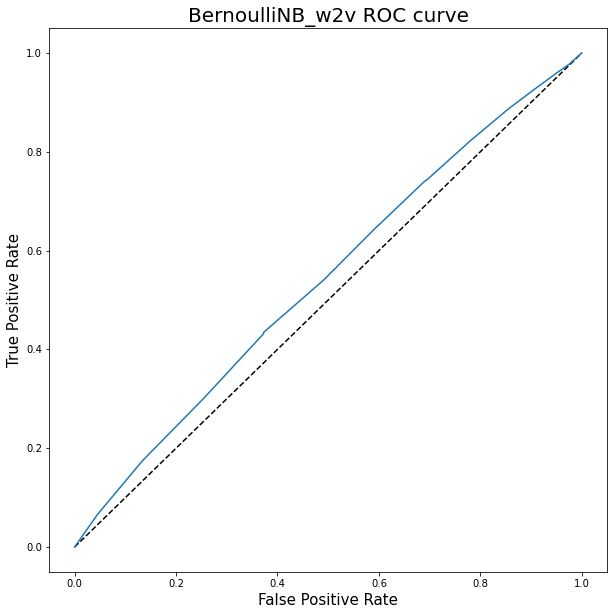

In [78]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, BernoulliNB(), model_title = 'BernoulliNB_w2v', result = result)

              precision    recall  f1-score   support

           0       0.61      0.46      0.53      2042
           1       0.55      0.69      0.61      1913

    accuracy                           0.57      3955
   macro avg       0.58      0.58      0.57      3955
weighted avg       0.58      0.57      0.57      3955



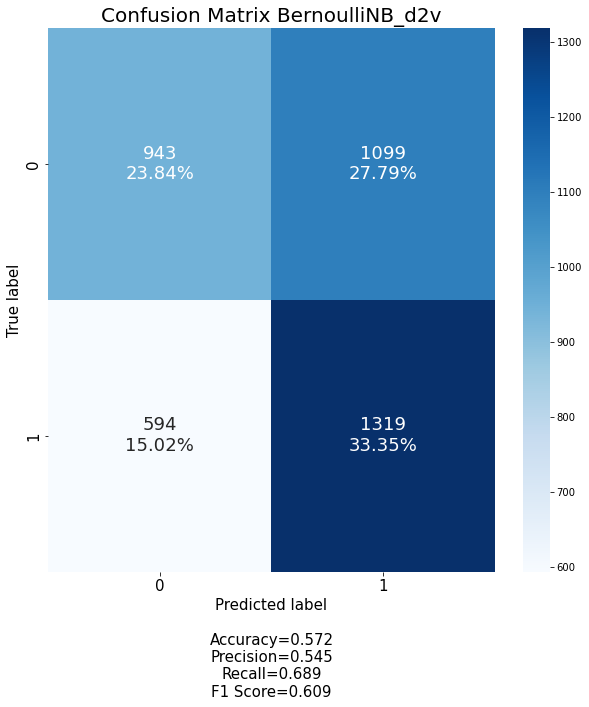

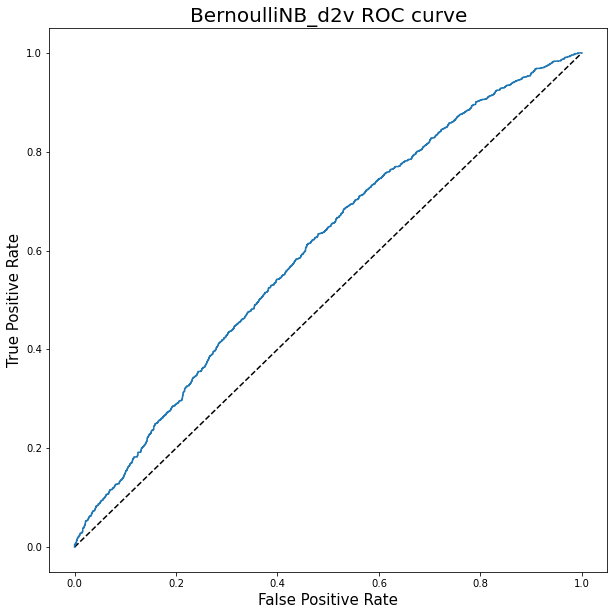

In [79]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, BernoulliNB(), model_title = 'BernoulliNB_d2v', result = result)

              precision    recall  f1-score   support

           0       0.58      0.57      0.58      2042
           1       0.55      0.56      0.56      1913

    accuracy                           0.57      3955
   macro avg       0.57      0.57      0.57      3955
weighted avg       0.57      0.57      0.57      3955



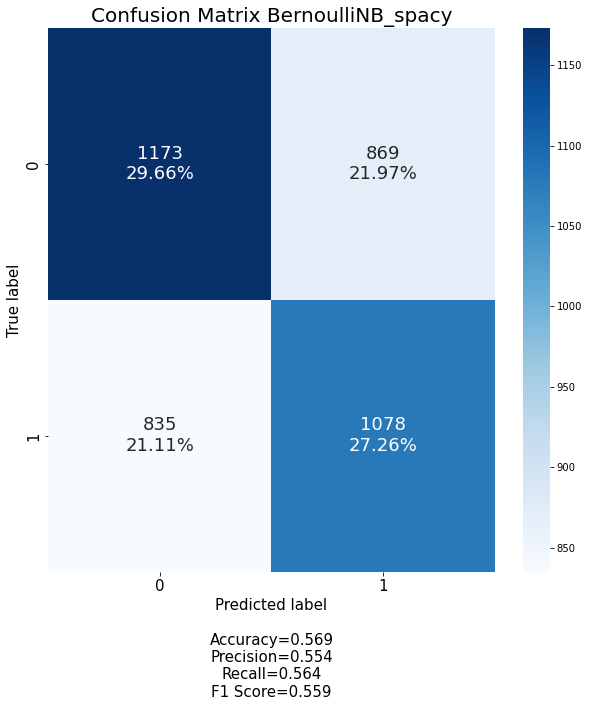

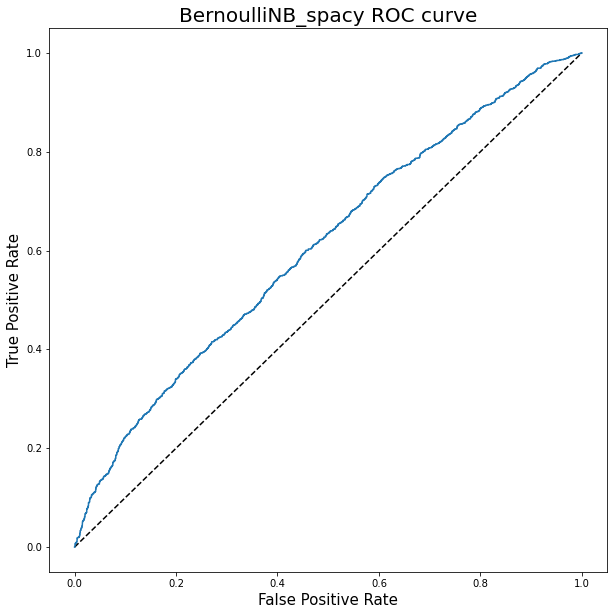

In [80]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, BernoulliNB(), model_title = 'BernoulliNB_spacy', result = result)

              precision    recall  f1-score   support

           0       0.54      0.51      0.52      2042
           1       0.51      0.54      0.52      1913

    accuracy                           0.52      3955
   macro avg       0.52      0.52      0.52      3955
weighted avg       0.53      0.52      0.52      3955



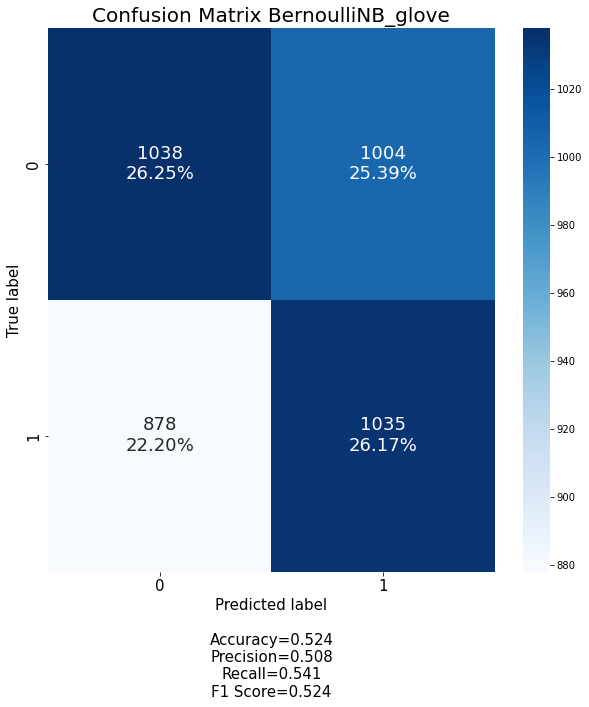

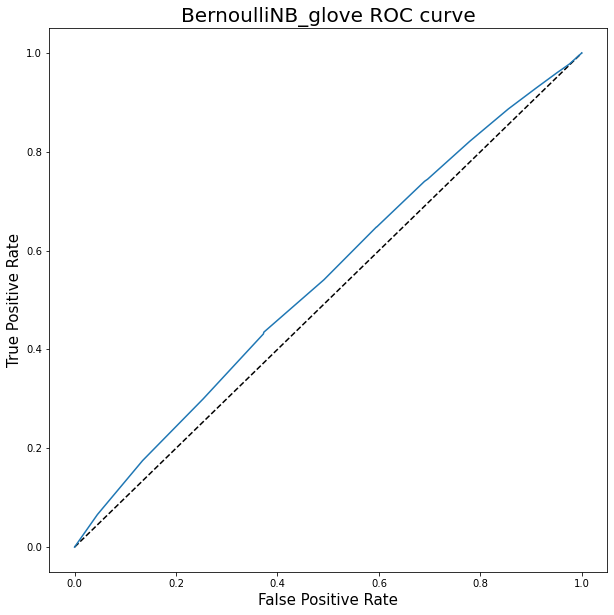

In [81]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, BernoulliNB(), model_title = 'BernoulliNB_glove', result = result)

### RandomForestClassifier

              precision    recall  f1-score   support

           0       0.79      0.60      0.68      2042
           1       0.66      0.83      0.73      1913

    accuracy                           0.71      3955
   macro avg       0.72      0.71      0.71      3955
weighted avg       0.72      0.71      0.71      3955



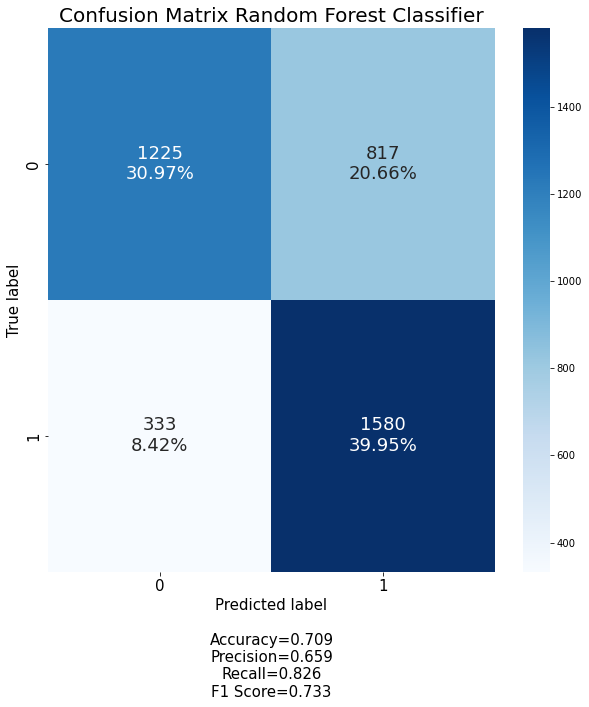

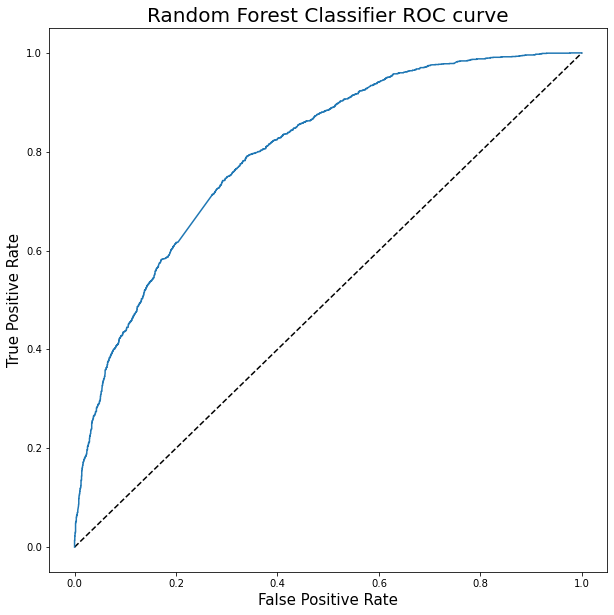

In [82]:
result = classification_result(X_train, y_train, X_test, y_test, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier', result = result)

              precision    recall  f1-score   support

           0       0.65      0.63      0.64      2042
           1       0.62      0.64      0.63      1913

    accuracy                           0.64      3955
   macro avg       0.64      0.64      0.64      3955
weighted avg       0.64      0.64      0.64      3955



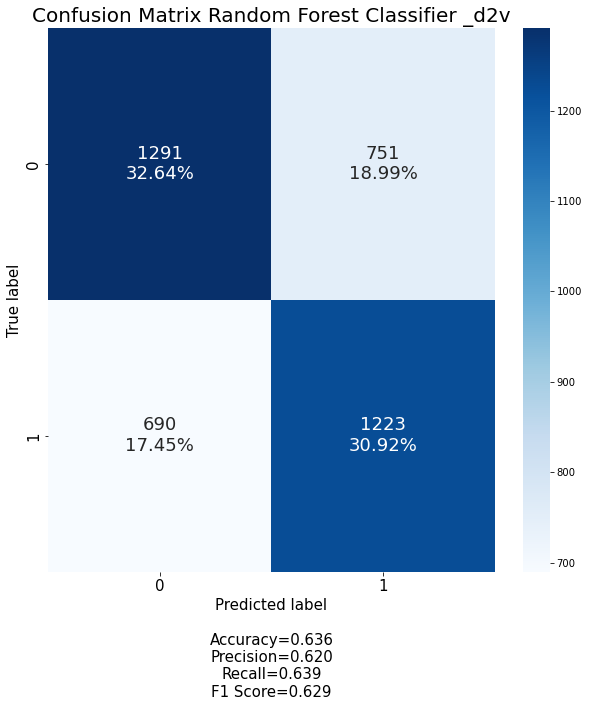

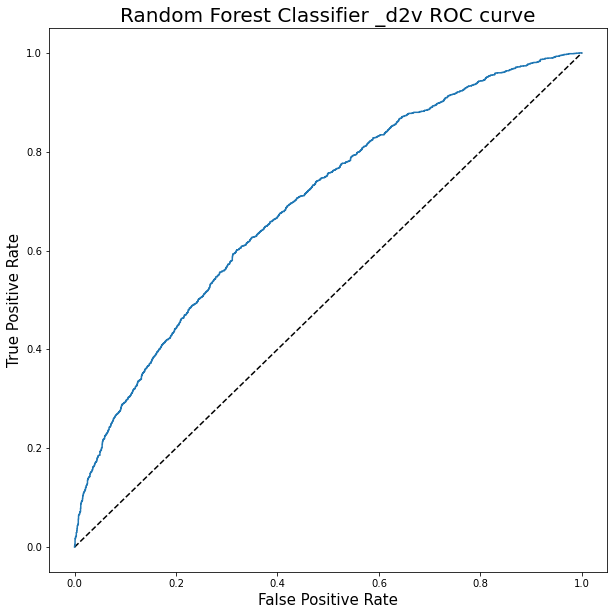

In [84]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier _d2v', result = result)

              precision    recall  f1-score   support

           0       0.62      1.00      0.76      2042
           1       1.00      0.34      0.51      1913

    accuracy                           0.68      3955
   macro avg       0.81      0.67      0.64      3955
weighted avg       0.80      0.68      0.64      3955



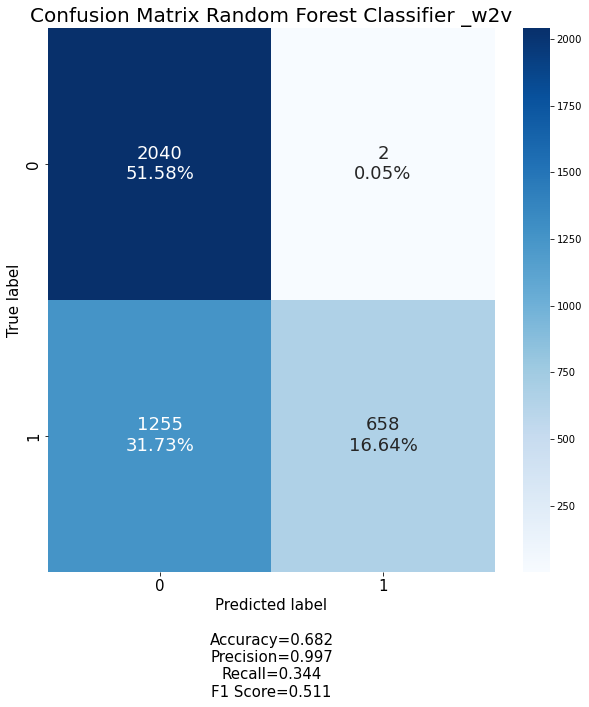

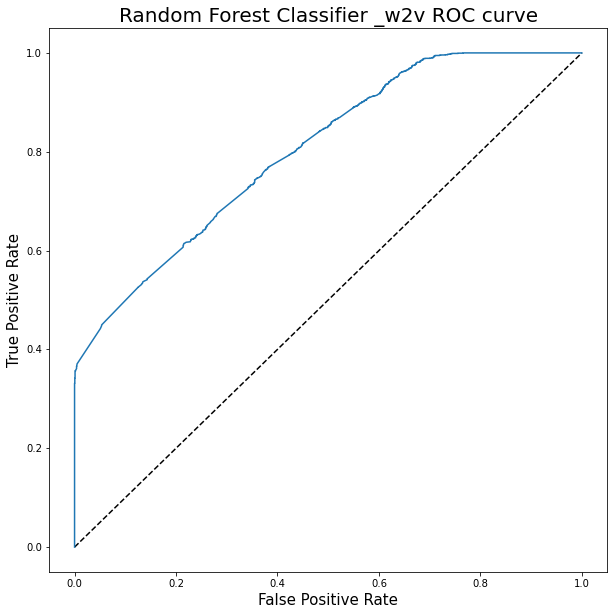

In [83]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier _w2v', result = result)

              precision    recall  f1-score   support

           0       0.62      1.00      0.76      2042
           1       1.00      0.34      0.51      1913

    accuracy                           0.68      3955
   macro avg       0.81      0.67      0.64      3955
weighted avg       0.80      0.68      0.64      3955



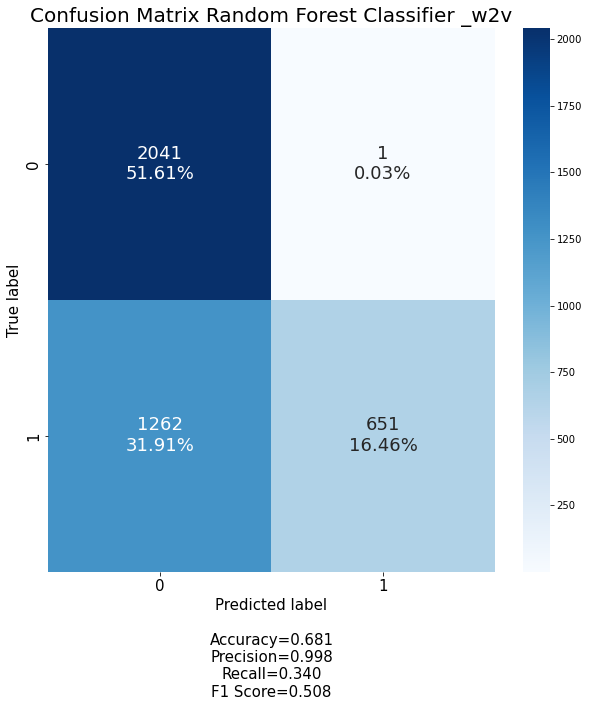

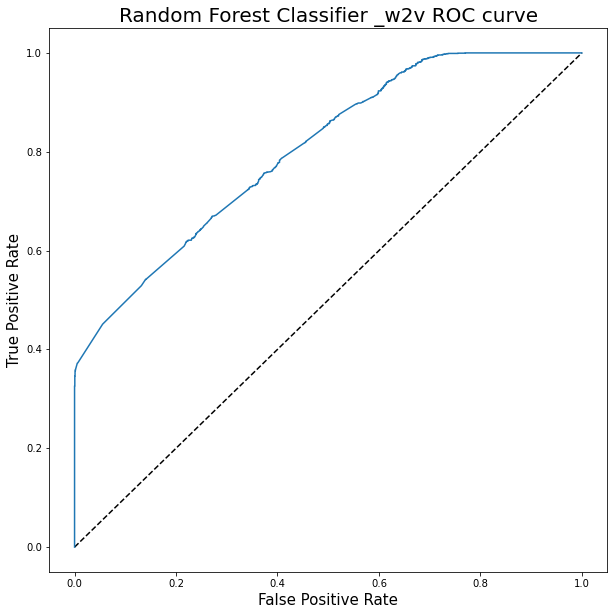

In [86]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier _w2v', result = result)

              precision    recall  f1-score   support

           0       0.64      0.61      0.62      2042
           1       0.60      0.63      0.61      1913

    accuracy                           0.62      3955
   macro avg       0.62      0.62      0.62      3955
weighted avg       0.62      0.62      0.62      3955



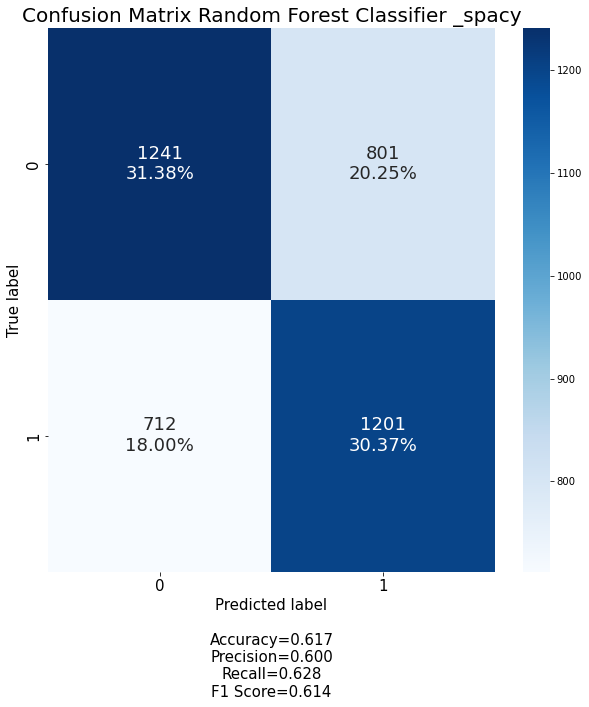

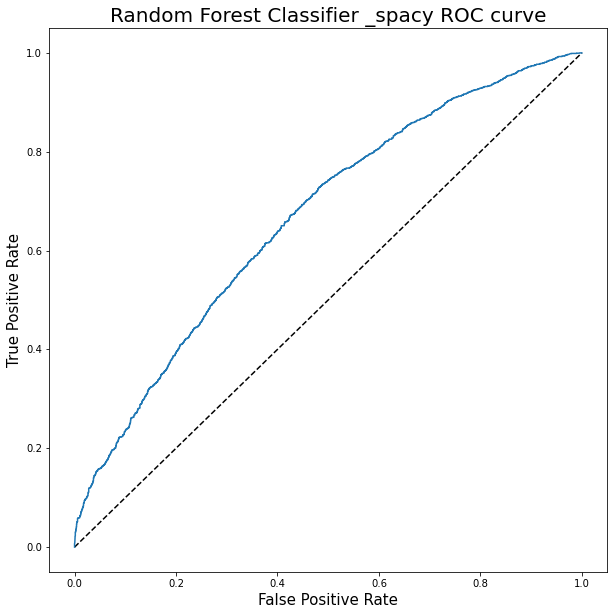

In [87]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, RandomForestClassifier(n_estimators=200, max_depth=15), model_title = 'Random Forest Classifier _spacy', result = result)

### KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.68      0.64      0.66      2042
           1       0.64      0.68      0.66      1913

    accuracy                           0.66      3955
   macro avg       0.66      0.66      0.66      3955
weighted avg       0.66      0.66      0.66      3955



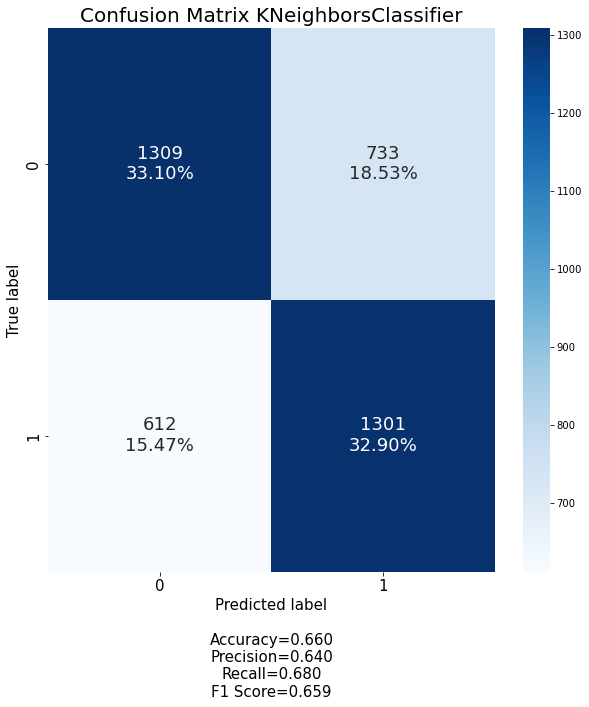

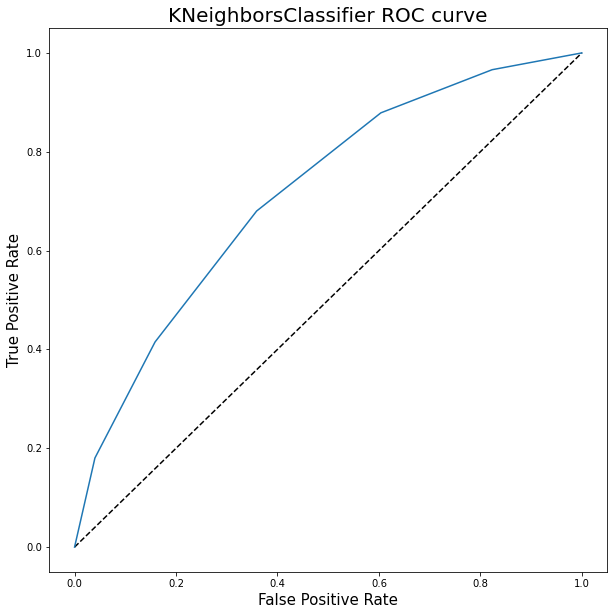

In [88]:
result = classification_result(X_train, y_train, X_test, y_test, KNeighborsClassifier(n_jobs=-1), model_title = 'KNeighborsClassifier', result = result)

In [152]:
#result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, KNeighborsClassifier(n_jobs=-1), model_title = 'KNeighborsClassifier', result = result)

### LGBMClassifier

              precision    recall  f1-score   support

           0       0.78      0.63      0.70      2042
           1       0.67      0.81      0.73      1913

    accuracy                           0.72      3955
   macro avg       0.73      0.72      0.72      3955
weighted avg       0.73      0.72      0.72      3955



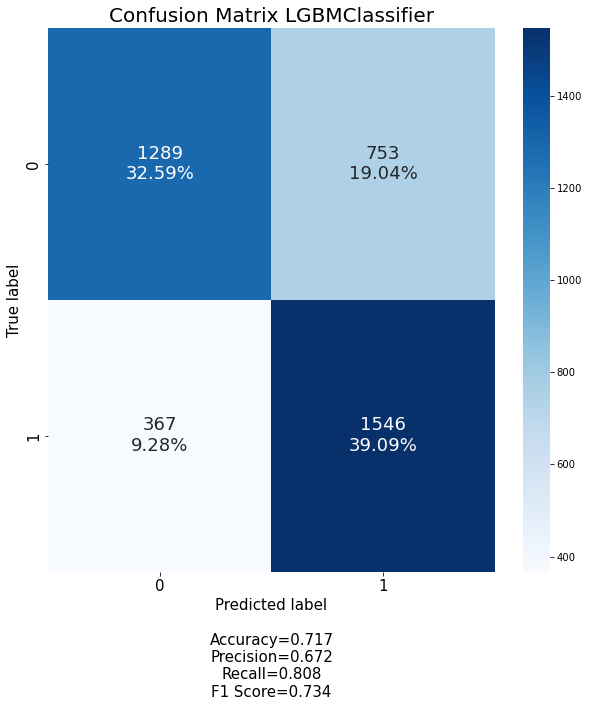

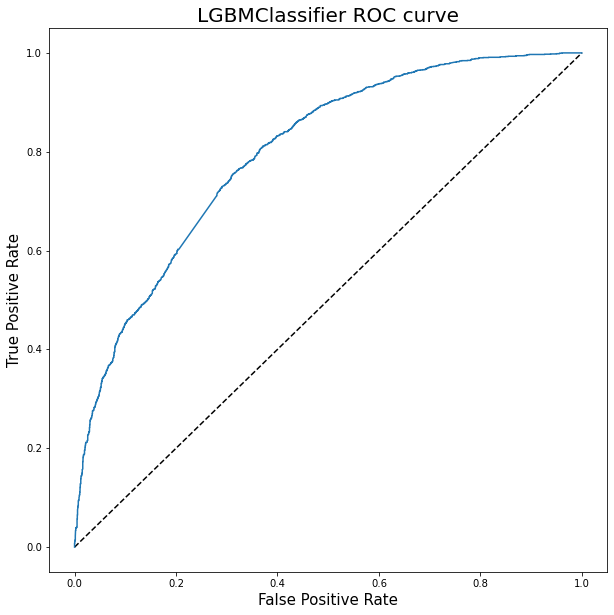

In [90]:
result = classification_result(X_train, y_train, X_test, y_test, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier', result = result)

              precision    recall  f1-score   support

           0       0.75      0.78      0.77      2042
           1       0.76      0.73      0.74      1913

    accuracy                           0.76      3955
   macro avg       0.76      0.76      0.76      3955
weighted avg       0.76      0.76      0.76      3955



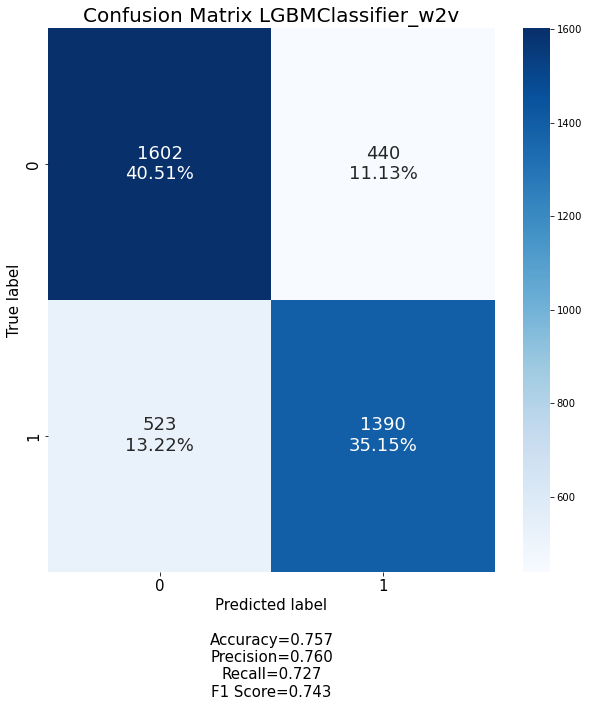

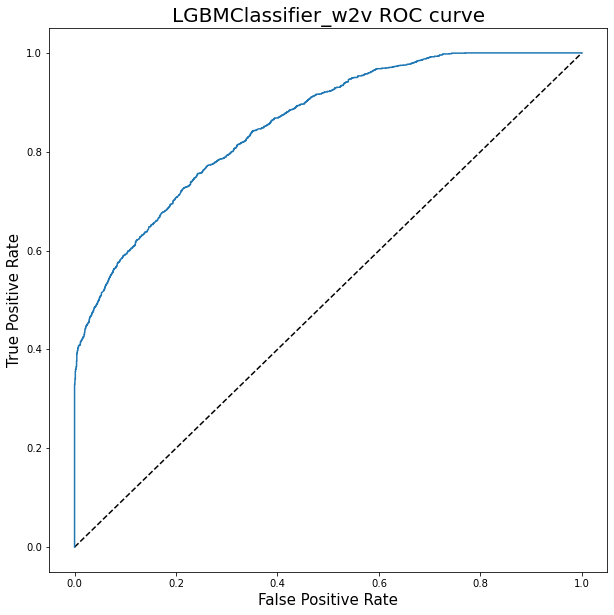

In [91]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier_w2v', result = result)

              precision    recall  f1-score   support

           0       0.64      0.64      0.64      2042
           1       0.61      0.62      0.62      1913

    accuracy                           0.63      3955
   macro avg       0.63      0.63      0.63      3955
weighted avg       0.63      0.63      0.63      3955



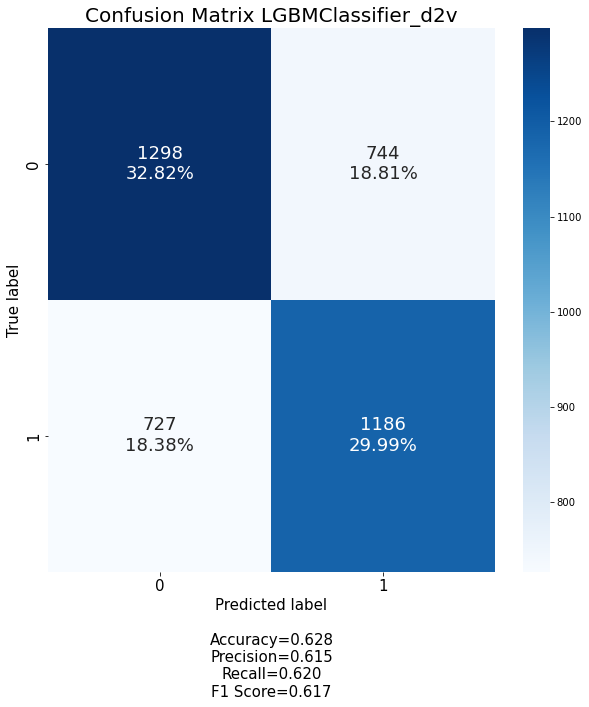

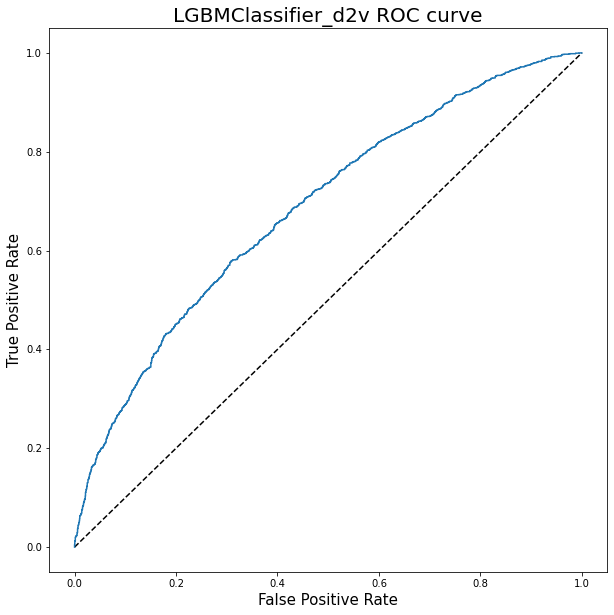

In [93]:
result = classification_result(X_train_d2v, y_train_d2v, X_test_d2v, y_test_d2v, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier_d2v', result = result)

              precision    recall  f1-score   support

           0       0.75      0.78      0.77      2042
           1       0.76      0.73      0.74      1913

    accuracy                           0.76      3955
   macro avg       0.76      0.76      0.76      3955
weighted avg       0.76      0.76      0.76      3955



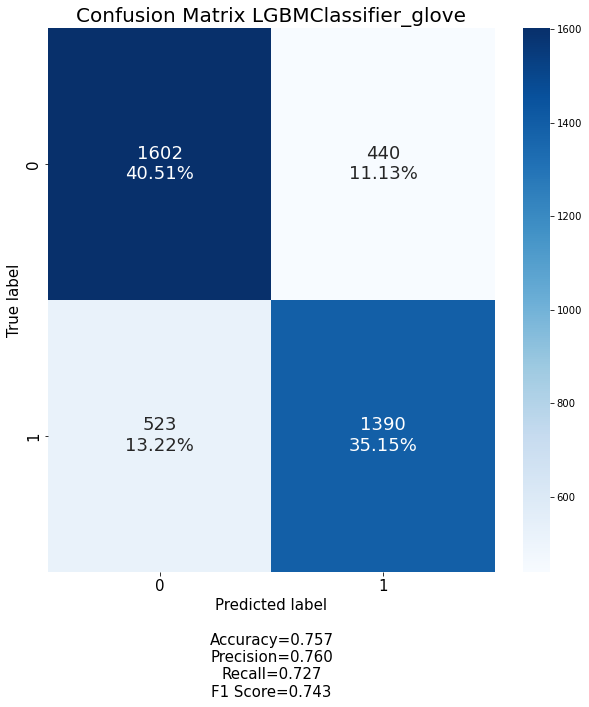

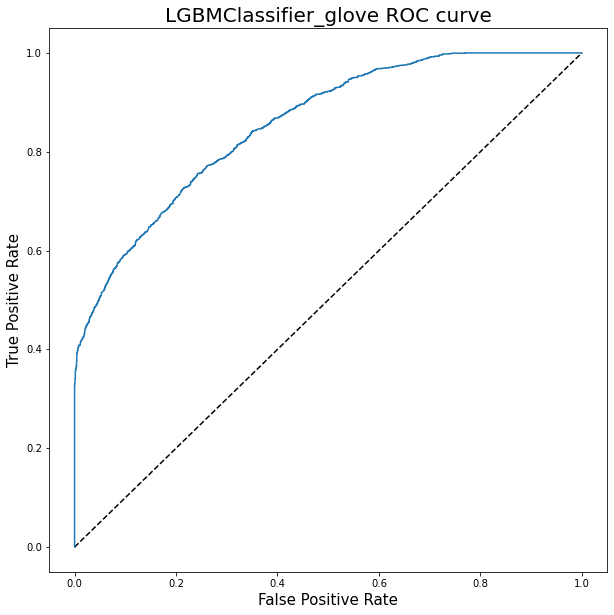

In [95]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier_glove', result = result)

              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2042
           1       0.60      0.62      0.61      1913

    accuracy                           0.61      3955
   macro avg       0.61      0.61      0.61      3955
weighted avg       0.61      0.61      0.61      3955



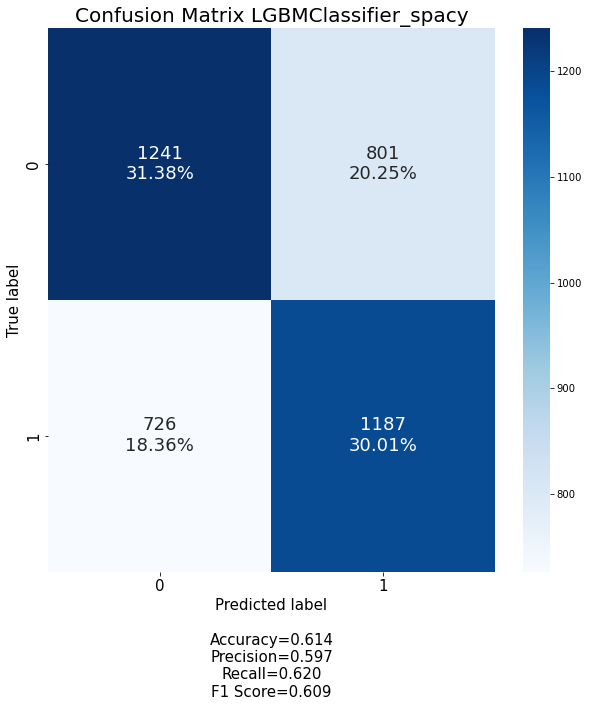

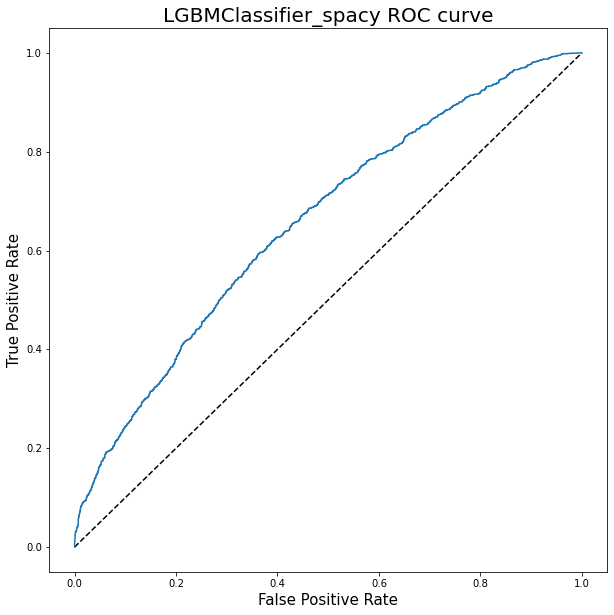

In [94]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, LGBMClassifier(
                objective='binary',
                n_jobs=-1,
                random_state=10), model_title = 'LGBMClassifier_spacy', result = result)

### XGBClassifier

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:47] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.78      0.61      0.69      2042
           1       0.66      0.82      0.73      1913

    accuracy                           0.71      3955
   macro avg       0.72      0.71      0.71      3955
weighted avg       0.72      0.71      0.71      3955



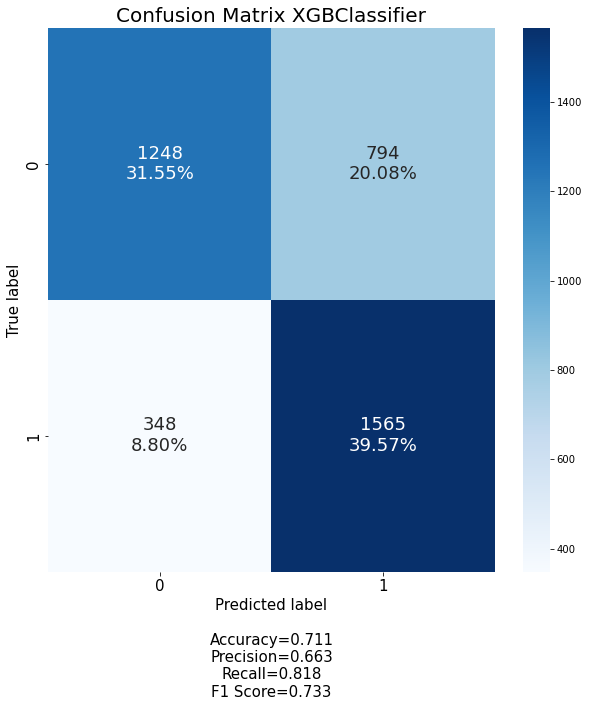

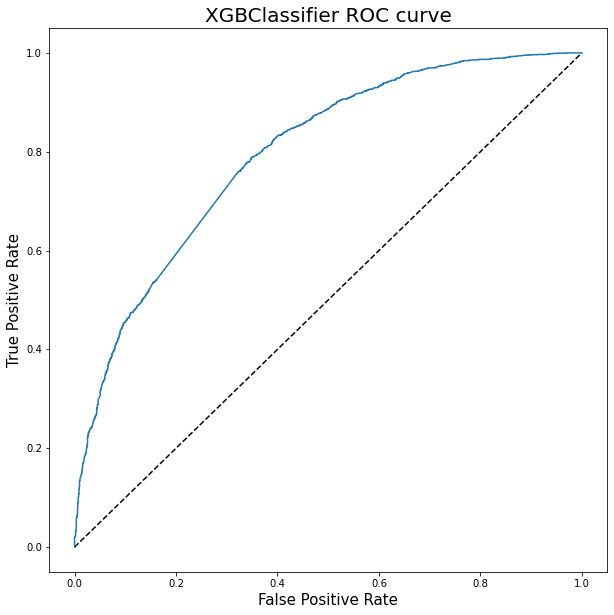

In [96]:
result = classification_result(X_train, y_train, X_test, y_test, XGBClassifier(objective='binary:logistic',
                                                                        n_jobs=-1,
                                                                        random_state=10), model_title = 'XGBClassifier', result = result)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:52:51] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2042
           1       0.76      0.74      0.75      1913

    accuracy                           0.76      3955
   macro avg       0.76      0.76      0.76      3955
weighted avg       0.76      0.76      0.76      3955



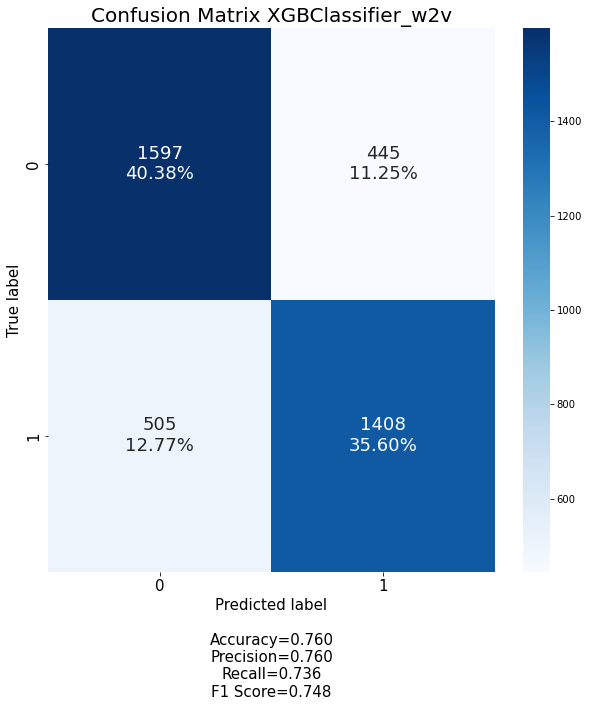

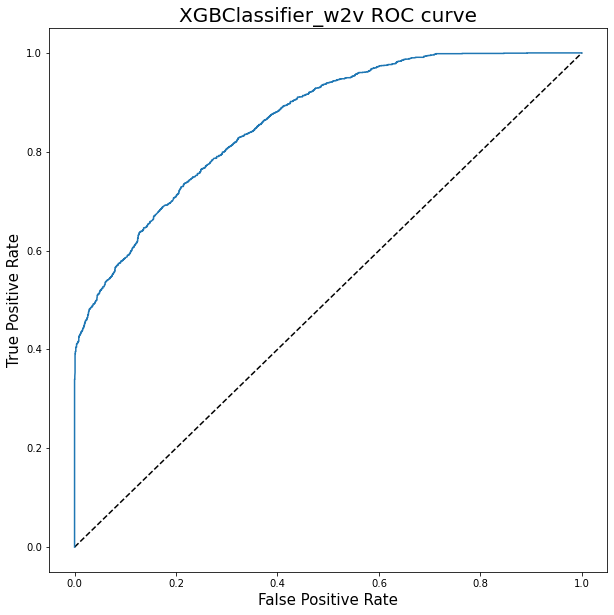

In [97]:
result = classification_result(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, XGBClassifier(objective='binary:logistic',
                                                                        n_jobs=-1,
                                                                        random_state=10), model_title = 'XGBClassifier_w2v', result = result)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:45] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2042
           1       0.76      0.74      0.75      1913

    accuracy                           0.76      3955
   macro avg       0.76      0.76      0.76      3955
weighted avg       0.76      0.76      0.76      3955



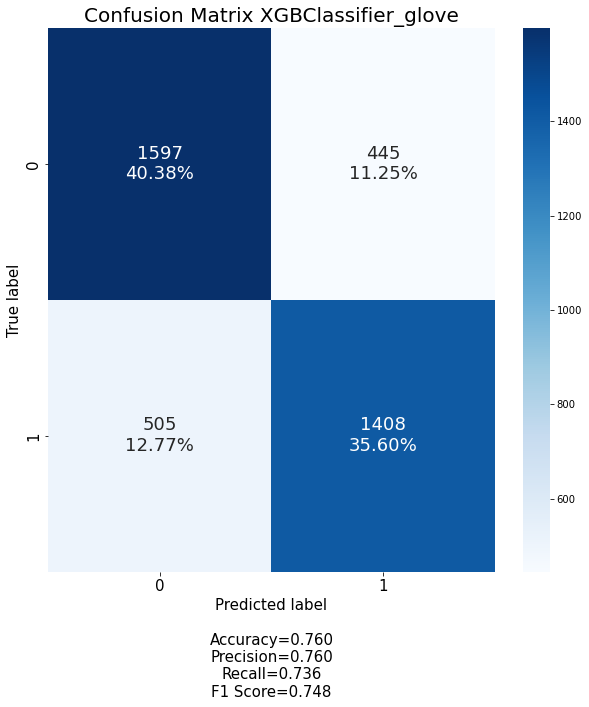

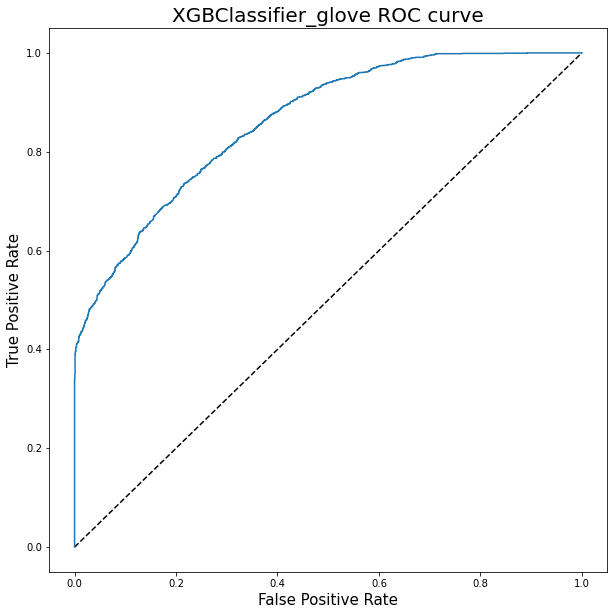

In [99]:
result = classification_result(X_train_glove, y_train_glove, X_test_glove, y_test_glove, XGBClassifier(objective='binary:logistic',
                                                                        n_jobs=-1,
                                                                        random_state=10), model_title = 'XGBClassifier_glove', result = result)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:53:03] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.61      0.59      0.60      2042
           1       0.58      0.59      0.58      1913

    accuracy                           0.59      3955
   macro avg       0.59      0.59      0.59      3955
weighted avg       0.59      0.59      0.59      3955



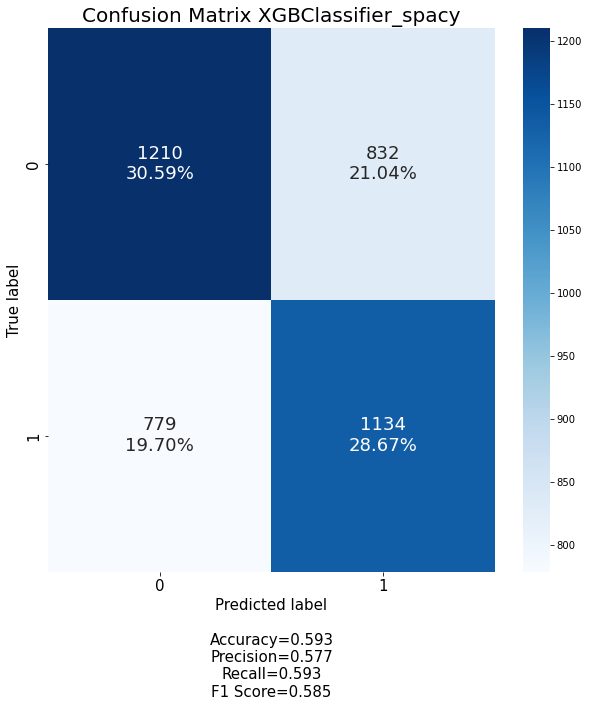

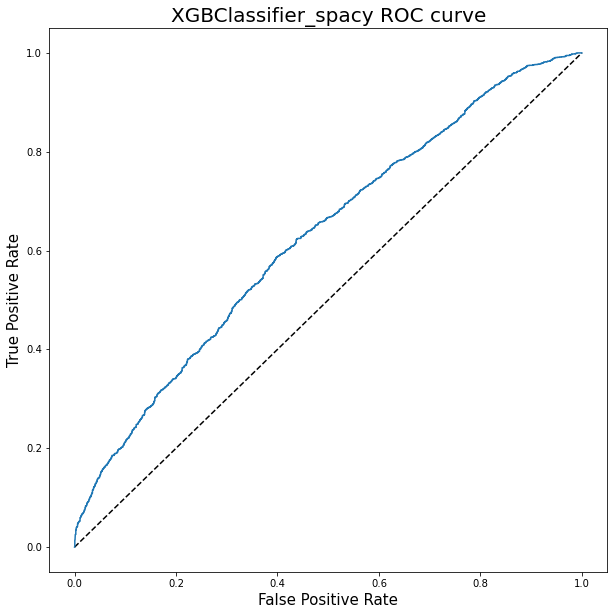

In [98]:
result = classification_result(X_train_spacy, y_train_spacy, X_test_spacy, y_test_spacy, XGBClassifier(objective='binary:logistic',
                                                                        n_jobs=-1,
                                                                        random_state=10), model_title = 'XGBClassifier_spacy', result = result)

In [102]:
result = pd.DataFrame(result)

In [113]:
result[result.index=='f1_score']

SVM   SVM_w2v   SVM_d2v  SVM_spacy  SVM_glove  \
f1_score  0.720658  0.379755  0.628022   0.607732    0.60979   

          Logistic Regression  Logistic Regression _w2v  \
f1_score             0.737157                  0.642269   

          Logistic Regression _doc2vec  Logistic Regression _spacy  \
f1_score                       0.62282                    0.607354   

          BernoulliNB  ...  KNeighborsClassifier  LGBMClassifier_w2v  \
f1_score     0.723448  ...              0.659235             0.74272   

          LGBMClassifier  LGBMClassifier_spacy  LGBMClassifier_d2v  \
f1_score        0.734093              0.608562            0.617226   

          LGBMClassifier_glove  XGBClassifier  XGBClassifier_w2v  \
f1_score               0.74272       0.732678           0.747743   

          XGBClassifier_spacy  XGBClassifier_glove  
f1_score             0.584687             0.747743  

[1 rows x 28 columns]

In [114]:
max(result[result.index=='f1_score'])

'XGBClassifier_w2v'

In [116]:
max(result[result.index=='precision'])

'XGBClassifier_w2v'

In [117]:
max(result[result.index=='recall'])

'XGBClassifier_w2v'

In [118]:
max(result[result.index=='accuracy'])

'XGBClassifier_w2v'

In [119]:
result.XGBClassifier_w2v

precision    0.759849
recall       0.736017
f1_score     0.747743
accuracy     0.759798
Name: XGBClassifier_w2v, dtype: float64

It seems that here BernoulliNB in terms of f1 score and accuracy that are both arround 0.72.

## Advanced custom models with Neuronal Networks (Keras)

Let us first make a recall of our data that consists of positive and negative tweents. We allready maked tokenization and cleaned or text data. To see the result of that let us see what it contais.

In [120]:
if os.path.exists("data/processed/processed_nlp_data.pkl.gz"):
    logger.info(">>> Loading cleaned and preprocessed data...")
    data = pd.read_pickle("data/processed/processed_nlp_data.pkl.gz")
    logger.info(f">>> OK : {len(data)} data loaded from pickle file.")

INFO:__main__:>>> Loading cleaned and preprocessed data...
INFO:__main__:>>> OK : 19773 data loaded from pickle file.


In [121]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data' + pkl_extension
vocabulary_file_path = vectorized_dataset_path + 'vocabulary_data' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Tfidf Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X = pickle.load(f)
    # Load vocabulary
    with (open(vocabulary_file_path, "rb")) as f:
        vocabulary = pickle.load(f)
else:
    logger.info(">>> Please create Tfidf Vectorized data...")

INFO:__main__:>>> Loading Tfidf Vectorized data...


In [122]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_doc2vec' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Doc2Vec Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_d2v = pickle.load(f)
else:
    logger.info(">>> Please create Doc2Vec Vectorized data...")

INFO:__main__:>>> Loading Doc2Vec Vectorized data...


In [123]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_w2v' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Word2Vec Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_w2v = pickle.load(f)
else:
    logger.info(">>> Please create Word2Vec Vectorized data...")

INFO:__main__:>>> Loading Word2Vec Vectorized data...


In [124]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_glove' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Glove Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_glove = pickle.load(f)
else:
    logger.info(">>> Please create Word2Vec Vectorized data...")

INFO:__main__:>>> Loading Glove Vectorized data...


In [125]:
pkl_extension = '.pkl'
vectorized_dataset_path = 'data/processed/vectorized/'
vectorized_dataset_file_path = vectorized_dataset_path + 'vectorized_data_spacy' + pkl_extension
if os.path.exists(vectorized_dataset_file_path):
    logger.info(">>> Loading Spacy Vectorized data...")
        
    # Load vectorized dataset
    with (open(vectorized_dataset_file_path, "rb")) as f:
        X_spacy = pickle.load(f)
else:
    logger.info(">>> Please create Spacy Vectorized data...")

INFO:__main__:>>> Loading Spacy Vectorized data...


### Neuronal Networks
#### Feed Forward Neuronal Networks model
##### FFNN on word counting vector
Now we use a simple feed forward neuronal network on word counting vector as input. The preprocessing of the dataset is already done with spacy package. We create a simple neuronal network with three hidden layers.

In [196]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)
model_name = "ffnn_on_count"
vocabulary_size = X.shape[1]

results_data_path = os.path.join("results")
model_file_path = os.path.join(results_data_path, model_name)

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="count",
        max_tokens=vocabulary_size,
        pad_to_max_tokens=True,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(Dense(25, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    #model.add(Dense(25, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/10


2022-09-16 09:48:49.021157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/99 [..............................] - ETA: 57s - loss: 0.6924 - accuracy: 0.5234

2022-09-16 09:48:49.635630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.6682

2022-09-16 09:48:51.160112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 2s 17ms/step - loss: 0.6573 - accuracy: 0.6682 - val_loss: 0.6101 - val_accuracy: 0.7140
Epoch 2/10
99/99 [==============================] - 2s 16ms/step - loss: 0.5422 - accuracy: 0.7752 - val_loss: 0.5568 - val_accuracy: 0.7244
Epoch 3/10
99/99 [==============================] - 2s 16ms/step - loss: 0.4607 - accuracy: 0.8100 - val_loss: 0.5440 - val_accuracy: 0.7323
Epoch 4/10
99/99 [==============================] - 1s 15ms/step - loss: 0.4057 - accuracy: 0.8376 - val_loss: 0.5505 - val_accuracy: 0.7332
Epoch 5/10
99/99 [==============================] - 1s 14ms/step - loss: 0.3631 - accuracy: 0.8578 - val_loss: 0.5597 - val_accuracy: 0.7253


INFO:tensorflow:Assets written to: results/ffnn_on_count/assets


Model: "ffnn_on_count"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_25 (Text  (None, 14138)            0         
 Vectorization)                                                  
                                                                 
 dense_108 (Dense)           (None, 25)                353475    
                                                                 
 dropout_12 (Dropout)        (None, 25)                0         
                                                                 
 dense_109 (Dense)           (None, 1)                 26        
                                                                 
Total params: 353,501
Trainable params: 353,501
Non-trainable params: 0
_________________________________________________________________
None


21/31 [===================>..........] - ETA: 0s

2022-09-16 09:49:01.321949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      2042
           1       0.70      0.76      0.73      1913

    accuracy                           0.73      3955
   macro avg       0.73      0.73      0.73      3955
weighted avg       0.73      0.73      0.73      3955



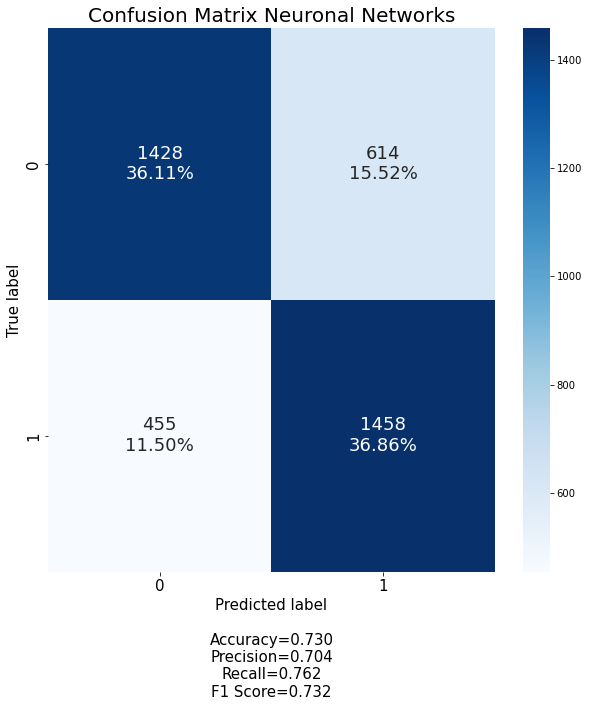

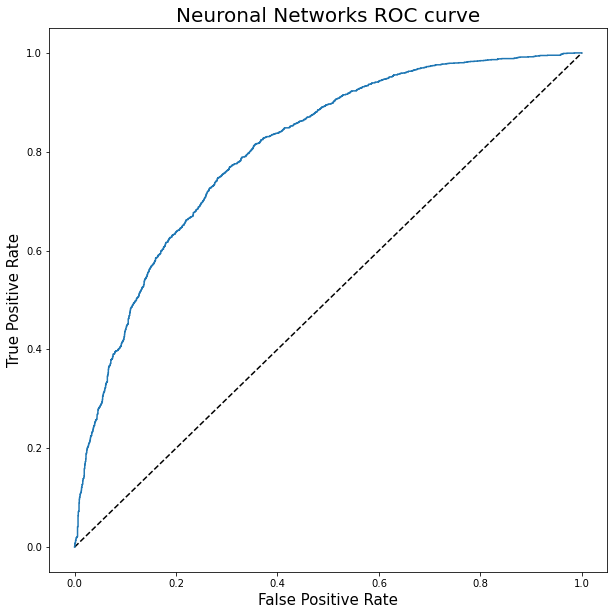

In [197]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]
print(classification_report(y_test, y_test_pred))
model_title = 'Neuronal Networks'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### FFNN on w2v vectorized data

In [200]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)
model_name_w2v = "ffnn_on_w2v"
vocabulary_size_w2v = X_w2v.shape[1]
model_file_path_w2v = os.path.join(results_data_path, model_name_w2v)
model_name = model_name_w2v
model_file_path = model_file_path_w2v
vocabulary_size = vocabulary_size_w2v


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # define NN model
    model = Sequential(name=model_name)
    model.add(Dense(25, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train_w2v,
        y_train_w2v,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20
 1/99 [..............................] - ETA: 32s - loss: 297.3139 - accuracy: 0.5234

2022-09-16 09:51:22.280413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 9ms/step - loss: 160.5509 - accuracy: 0.4960 - val_loss: 46.0784 - val_accuracy: 0.4880
Epoch 2/20
 1/99 [..............................] - ETA: 0s - loss: 107.7574 - accuracy: 0.4766

2022-09-16 09:51:23.166072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 7ms/step - loss: 83.4178 - accuracy: 0.5049 - val_loss: 27.5492 - val_accuracy: 0.4975
Epoch 3/20
99/99 [==============================] - 1s 7ms/step - loss: 57.6856 - accuracy: 0.5049 - val_loss: 20.3328 - val_accuracy: 0.4915
Epoch 4/20
99/99 [==============================] - 1s 7ms/step - loss: 37.0026 - accuracy: 0.5078 - val_loss: 12.8213 - val_accuracy: 0.4877
Epoch 5/20
99/99 [==============================] - 1s 7ms/step - loss: 22.3467 - accuracy: 0.5010 - val_loss: 8.2843 - val_accuracy: 0.4959
Epoch 6/20
99/99 [==============================] - 1s 7ms/step - loss: 12.1607 - accuracy: 0.4998 - val_loss: 4.7015 - val_accuracy: 0.4861
Epoch 7/20
99/99 [==============================] - 1s 7ms/step - loss: 6.2585 - accuracy: 0.4993 - val_loss: 2.4221 - val_accuracy: 0.4870
Epoch 8/20
99/99 [==============================] - 1s 7ms/step - loss: 2.6097 - accuracy: 0.5038 - val_loss: 1.4347 - val_accuracy: 0.5123
Epoch 9/20
99/99 [=====

INFO:tensorflow:Assets written to: results/ffnn_on_w2v/assets


Model: "ffnn_on_w2v"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_112 (Dense)           (None, 25)                2525      
                                                                 
 dropout_14 (Dropout)        (None, 25)                0         
                                                                 
 dense_113 (Dense)           (None, 1)                 26        
                                                                 
Total params: 2,551
Trainable params: 2,551
Non-trainable params: 0
_________________________________________________________________
None


31/31 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.52      0.49      0.50      2042
           1       0.49      0.52      0.50      1913

    accuracy                           0.50      3955
   macro avg       0.50      0.50      0.50      3955
weighted avg       0.50      0.50      0.50      3955



2022-09-16 09:51:42.401354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


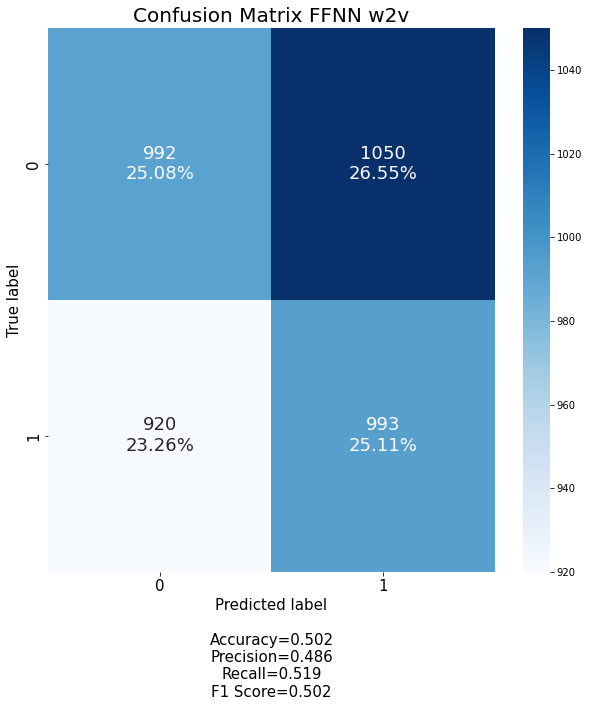

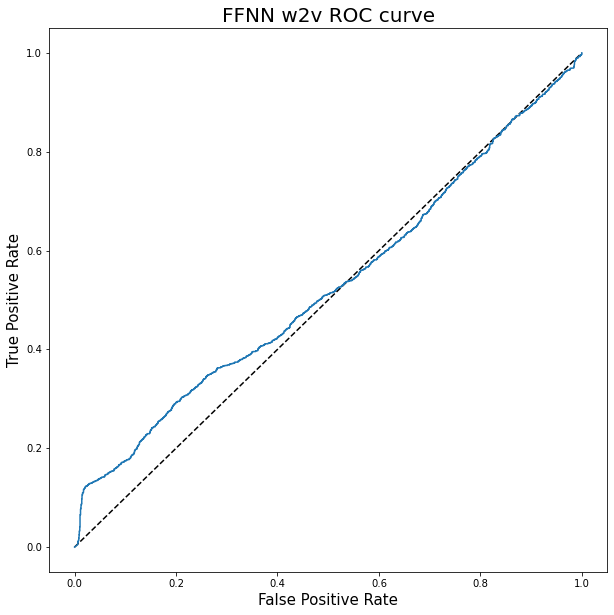

In [201]:
y_test_pred_proba_w2v = model.predict(
    X_test_w2v,
    batch_size=128
)

y_test_pred_w2v = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_w2v]

print(classification_report(y_test_w2v, y_test_pred_w2v))

model_title = 'FFNN w2v'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test_w2v, y_test_pred_w2v), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test_w2v, y_test_pred_proba_w2v)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### FFNN on spacy vectorized data

In [207]:
results_data_path = os.path.join("results")
X_train_spacy, X_test_spacy, y_train_spacy, y_test_spacy = train_test_split(X_spacy, data.Target, train_size = 0.8, random_state = 1)
model_name_spacy = "ffnn_on_spacy"
vocabulary_size_spacy = X_spacy.shape[1]
model_file_path_spacy = os.path.join(results_data_path, model_name_spacy)
model_name = model_name_spacy
model_file_path = model_file_path_spacy
vocabulary_size = vocabulary_size_spacy


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # define NN model
    model = Sequential(name=model_name)
    model.add(Dense(25, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train_spacy,
        y_train_spacy,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20
 1/99 [..............................] - ETA: 33s - loss: 0.7231 - accuracy: 0.5078

2022-09-16 09:55:02.104626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 9ms/step - loss: 0.6912 - accuracy: 0.5390 - val_loss: 0.6907 - val_accuracy: 0.5430
Epoch 2/20
 1/99 [..............................] - ETA: 0s - loss: 0.6834 - accuracy: 0.5312

2022-09-16 09:55:03.034234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 1s 7ms/step - loss: 0.6801 - accuracy: 0.5624 - val_loss: 0.6854 - val_accuracy: 0.5692
Epoch 3/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6741 - accuracy: 0.5774 - val_loss: 0.6796 - val_accuracy: 0.5809
Epoch 4/20
99/99 [==============================] - 1s 7ms/step - loss: 0.6679 - accuracy: 0.5899 - val_loss: 0.6762 - val_accuracy: 0.5809
Epoch 5/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6644 - accuracy: 0.5944 - val_loss: 0.6783 - val_accuracy: 0.5806
Epoch 6/20
99/99 [==============================] - 1s 7ms/step - loss: 0.6609 - accuracy: 0.5981 - val_loss: 0.6753 - val_accuracy: 0.5819
Epoch 7/20
99/99 [==============================] - 1s 7ms/step - loss: 0.6567 - accuracy: 0.6043 - val_loss: 0.6718 - val_accuracy: 0.5964
Epoch 8/20
99/99 [==============================] - 1s 6ms/step - loss: 0.6559 - accuracy: 0.6095 - val_loss: 0.6693 - val_accuracy: 0.5967
Epoch 9/20
99/99 [=============

INFO:tensorflow:Assets written to: results/ffnn_on_spacy/assets


Model: "ffnn_on_spacy"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 25)                2425      
                                                                 
 dropout_18 (Dropout)        (None, 25)                0         
                                                                 
 dense_121 (Dense)           (None, 1)                 26        
                                                                 
Total params: 2,451
Trainable params: 2,451
Non-trainable params: 0
_________________________________________________________________
None


31/31 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.61      0.71      0.66      2042
           1       0.63      0.53      0.57      1913

    accuracy                           0.62      3955
   macro avg       0.62      0.62      0.62      3955
weighted avg       0.62      0.62      0.62      3955



2022-09-16 09:55:21.531508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


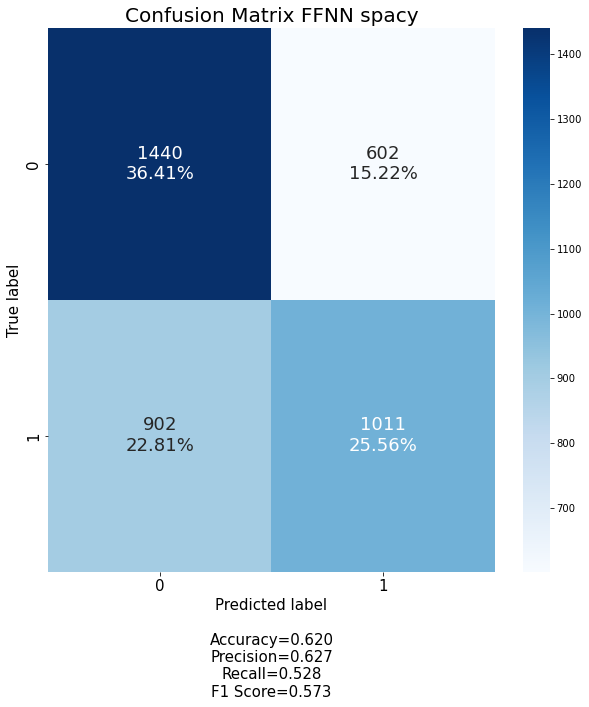

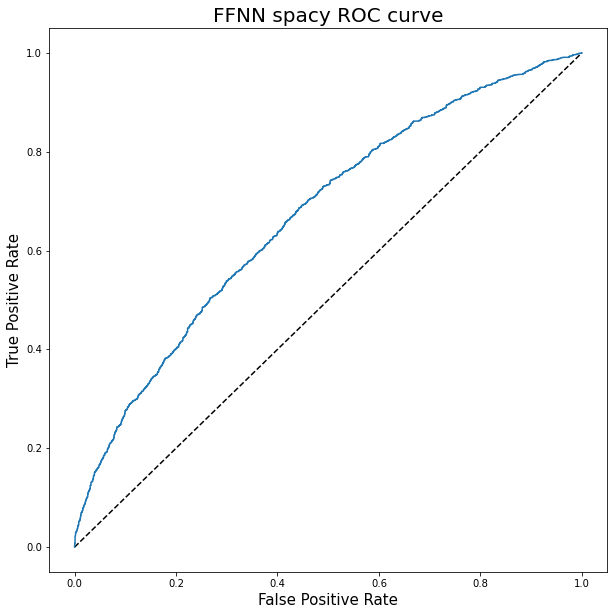

In [208]:
y_test_pred_proba_spacy = model.predict(
    X_test_spacy,
    batch_size=128
)

y_test_pred_spacy = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_spacy]
print(classification_report(y_test_spacy, y_test_pred_spacy))

model_title = 'FFNN spacy'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test_spacy, y_test_pred_spacy), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test_spacy, y_test_pred_proba_spacy)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

First I will start by tokenizing the data. But, here instead of using TfidfVectorizer tokenization we shall use using the pretrained Word Embedding model like GloVe & Word2Vec model in order to tokenize our dataset. These two models shows performace in the real world classification problems. For a clarification of what meens World Embedding, it is one of the most popular representation of document vocabulary capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. It's a feature vector representation of words which are used for other natural language processing applications, therefore it is taken here as a vectorization step of our tweet classification approach. For the begining we will start by trying the world2vec model on our dataset.

##### FFNN using embedding layer

In [209]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)
model_name = "ffnn_on_count_embedding"
max_features = 10000
embedding_dim = 100
sequence_length = 30
vocabulary_size = X.shape[1]

results_data_path = os.path.join("results")
model_file_path = os.path.join(results_data_path, model_name)

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    
    # Embedding layer
    model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )
    model.add(Flatten())
    
    
    model.add(Dense(25, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="ROC_AUC"),
            AUC(curve="PR", name="AP"),
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=10,
        use_multiprocessing=True,
    )

    model.save(model_file_path)


print(model.summary())

2022-09-16 09:56:45.587748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-16 09:56:46.227637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6815 - accuracy: 0.5657 - ROC_AUC: 0.6013 - AP: 0.6118

2022-09-16 09:56:50.130493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 5s 40ms/step - loss: 0.6815 - accuracy: 0.5657 - ROC_AUC: 0.6013 - AP: 0.6118 - val_loss: 0.6399 - val_accuracy: 0.6653 - val_ROC_AUC: 0.7604 - val_AP: 0.7502
Epoch 2/10
99/99 [==============================] - 3s 28ms/step - loss: 0.5438 - accuracy: 0.7452 - ROC_AUC: 0.8139 - AP: 0.8036 - val_loss: 0.5564 - val_accuracy: 0.7155 - val_ROC_AUC: 0.7911 - val_AP: 0.7744
Epoch 3/10
99/99 [==============================] - 3s 27ms/step - loss: 0.3961 - accuracy: 0.8334 - ROC_AUC: 0.9078 - AP: 0.9066 - val_loss: 0.5841 - val_accuracy: 0.7130 - val_ROC_AUC: 0.7864 - val_AP: 0.7642
Epoch 4/10
99/99 [==============================] - 3s 26ms/step - loss: 0.2776 - accuracy: 0.8974 - ROC_AUC: 0.9572 - AP: 0.9572 - val_loss: 0.6329 - val_accuracy: 0.7152 - val_ROC_AUC: 0.7723 - val_AP: 0.7461


INFO:tensorflow:Assets written to: results/ffnn_on_count_embedding/assets


Model: "ffnn_on_count_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_26 (Text  (None, 30)               0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 30, 100)           1000000   
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense_122 (Dense)           (None, 25)                75025     
                                                                 
 dropout_19 (Dropout)        (None, 25)                0         
                                                                 
 dense_123 (Dense)           (None, 1)                 26        
                                           

31/31 [==============================] - 0s 3ms/step


2022-09-16 09:57:33.548927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.73      0.70      0.71      2042
           1       0.69      0.72      0.71      1913

    accuracy                           0.71      3955
   macro avg       0.71      0.71      0.71      3955
weighted avg       0.71      0.71      0.71      3955



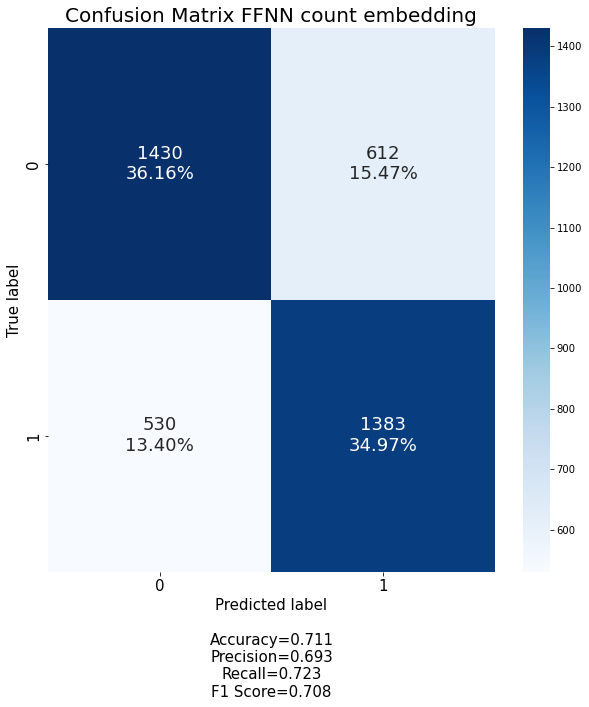

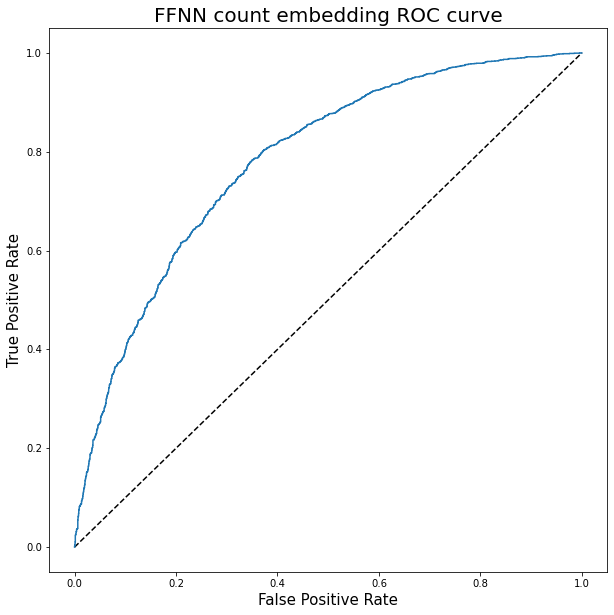

In [210]:
y_test_pred_proba_count_embeding = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_count_embeding = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_count_embeding]
print(classification_report(y_test, y_test_pred_count_embeding))
model_title = 'FFNN count embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_count_embeding), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_count_embeding)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### FFNN on w2v with embedding layer

In [268]:
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)
model_name_w2v = "ffnn_on_w2v_embedding"
vocabulary_size_w2v = X_w2v.shape[1]
model_file_path_w2v = os.path.join(results_data_path, model_name_w2v)
model_name = model_name_w2v
model_file_path = model_file_path_w2v
vocabulary_size = vocabulary_size_w2v


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_w2v], input_length=100, trainable=False)
    
    # define NN model
    model = Sequential(name=model_name)
    model.add(embedding_layer)
    model.add(Flatten())
    
    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train_w2v,
        y_train_w2v,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20


2022-09-16 11:12:07.706942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5258

2022-09-16 11:12:08.927579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 2s 13ms/step - loss: 0.6924 - accuracy: 0.5258 - val_loss: 0.6917 - val_accuracy: 0.5310
Epoch 2/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6886 - accuracy: 0.5725 - val_loss: 0.6871 - val_accuracy: 0.5796
Epoch 3/20
99/99 [==============================] - 1s 8ms/step - loss: 0.6817 - accuracy: 0.6122 - val_loss: 0.6819 - val_accuracy: 0.5879
Epoch 4/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6719 - accuracy: 0.6238 - val_loss: 0.6760 - val_accuracy: 0.5857
Epoch 5/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6613 - accuracy: 0.6312 - val_loss: 0.6692 - val_accuracy: 0.5838
Epoch 6/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6520 - accuracy: 0.6360 - val_loss: 0.6652 - val_accuracy: 0.5901
Epoch 7/20
99/99 [==============================] - 1s 9ms/step - loss: 0.6450 - accuracy: 0.6400 - val_loss: 0.6657 - val_accuracy: 0.5875
Epoch 8/20
99/99 [============

INFO:tensorflow:Assets written to: results/ffnn_on_w2v_embedding/assets


Model: "ffnn_on_w2v_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 100, 100)          1413900   
                                                                 
 flatten_11 (Flatten)        (None, 10000)             0         
                                                                 
 dense_181 (Dense)           (None, 25)                250025    
                                                                 
 dropout_55 (Dropout)        (None, 25)                0         
                                                                 
 dense_182 (Dense)           (None, 1)                 26        
                                                                 
Total params: 1,663,951
Trainable params: 250,051
Non-trainable params: 1,413,900
_________________________________________________________________
None


31/31 [==============================] - 0s 4ms/step


2022-09-16 11:12:26.161103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.62      0.59      0.61      2042
           1       0.59      0.62      0.60      1913

    accuracy                           0.61      3955
   macro avg       0.61      0.61      0.61      3955
weighted avg       0.61      0.61      0.61      3955



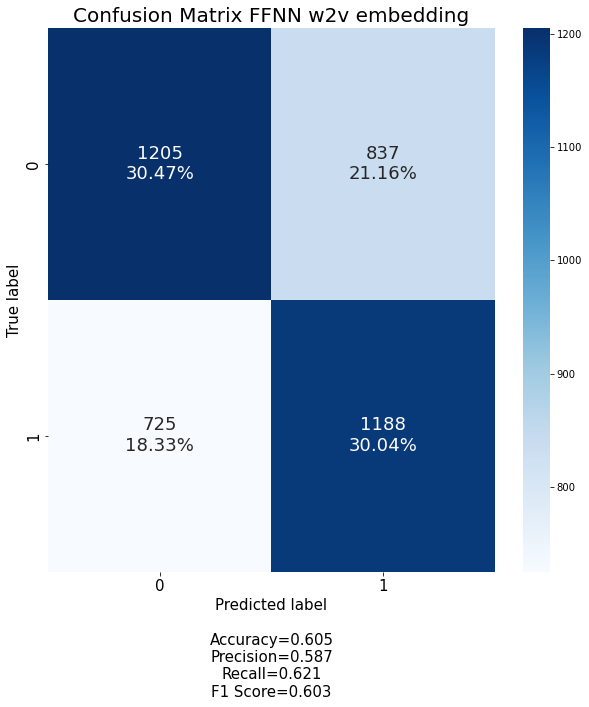

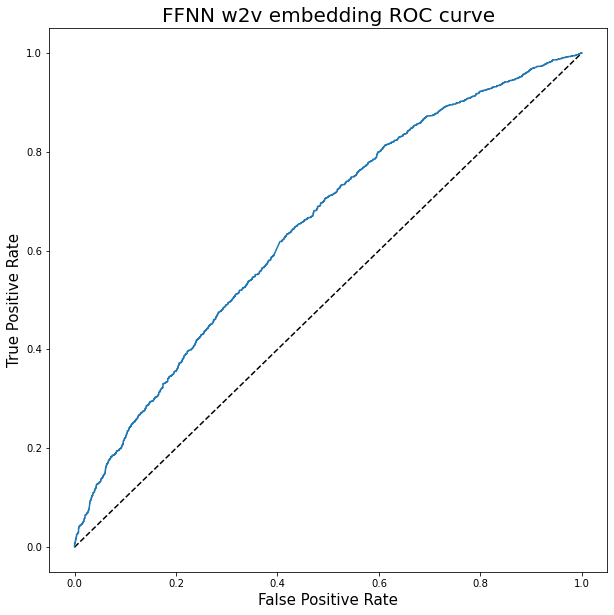

In [269]:
y_test_pred_proba_w2v = model.predict(
    X_test_w2v,
    batch_size=128
)

y_test_pred_w2v = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_w2v]

print(classification_report(y_test_w2v, y_test_pred_w2v))

model_title = 'FFNN w2v embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test_w2v, y_test_pred_w2v), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test_w2v, y_test_pred_proba_w2v)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### FFNN on glove with embedding layer

In [270]:
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, data.Target, train_size = 0.8, random_state = 1)
model_name_glove = "ffnn_on_glove_embedding"
vocabulary_size_glove = X_glove.shape[1]
model_file_path_glove = os.path.join(results_data_path, model_name_glove)
model_name = model_name_glove
model_file_path = model_file_path_glove
vocabulary_size = vocabulary_size_glove


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    embedding_layer = Embedding(vocabulary_size, 100, weights=[embedding_matrix_glove], input_length=100, trainable=False)
    
    # define NN model
    model = Sequential(name=model_name)
    model.add(embedding_layer)
    model.add(Flatten())
    
    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train_glove,
        y_train_glove,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20


2022-09-16 11:15:21.800651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.6068

2022-09-16 11:15:23.066989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 2s 14ms/step - loss: 0.6547 - accuracy: 0.6068 - val_loss: 0.6229 - val_accuracy: 0.6549
Epoch 2/20
99/99 [==============================] - 1s 9ms/step - loss: 0.5960 - accuracy: 0.6803 - val_loss: 0.6147 - val_accuracy: 0.6590
Epoch 3/20
99/99 [==============================] - 1s 9ms/step - loss: 0.5681 - accuracy: 0.7029 - val_loss: 0.6170 - val_accuracy: 0.6577
Epoch 4/20
99/99 [==============================] - 1s 9ms/step - loss: 0.5486 - accuracy: 0.7178 - val_loss: 0.6155 - val_accuracy: 0.6558


INFO:tensorflow:Assets written to: results/ffnn_on_glove_embedding/assets


Model: "ffnn_on_glove_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 100, 100)          1413900   
                                                                 
 flatten_12 (Flatten)        (None, 10000)             0         
                                                                 
 dense_183 (Dense)           (None, 25)                250025    
                                                                 
 dropout_56 (Dropout)        (None, 25)                0         
                                                                 
 dense_184 (Dense)           (None, 1)                 26        
                                                                 
Total params: 1,663,951
Trainable params: 250,051
Non-trainable params: 1,413,900
_________________________________________________________________
None


31/31 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.68      0.63      0.65      2042
           1       0.63      0.69      0.66      1913

    accuracy                           0.66      3955
   macro avg       0.66      0.66      0.66      3955
weighted avg       0.66      0.66      0.66      3955



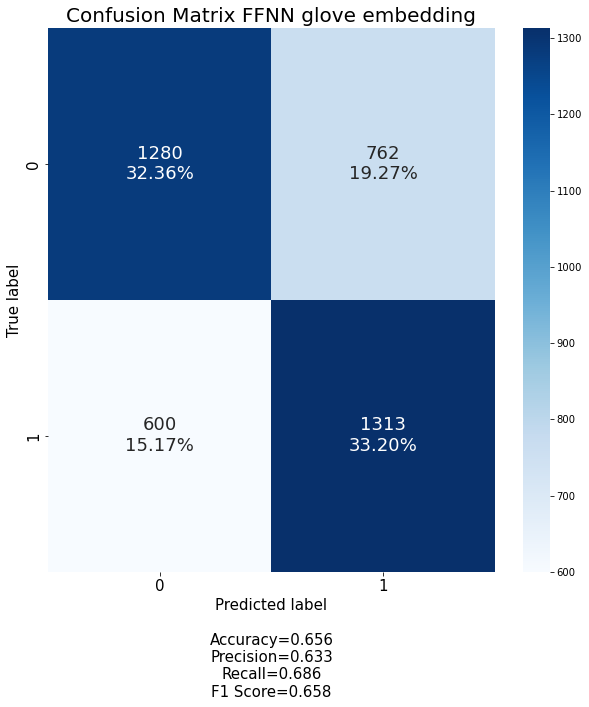

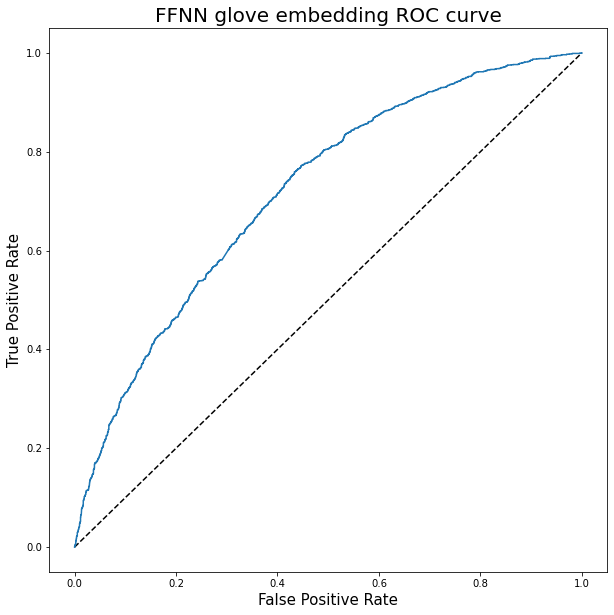

In [272]:
y_test_pred_proba_glove = model.predict(
    X_test_glove,
    batch_size=128
)

y_test_pred_glove = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_glove]

print(classification_report(y_test_glove, y_test_pred_glove))

model_title = 'FFNN glove embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test_glove, y_test_pred_glove), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test_glove, y_test_pred_proba_glove)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

#### RNN (Recurrent Neural Network) models

##### RNN on word counting vector with embedding layer

In [273]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "rnn_on_embedded"
model_file_path = os.path.join(results_data_path, model_name)

# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )

    # RNN layer
    model.add(SimpleRNN(units=rnn_units, dropout=0.2))

    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    
    #model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

2022-09-16 11:18:43.950446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-16 11:18:44.637680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.5976

2022-09-16 11:19:32.745741: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 50s 495ms/step - loss: 0.6556 - accuracy: 0.5976 - val_loss: 0.6115 - val_accuracy: 0.6552
Epoch 2/10
99/99 [==============================] - 46s 461ms/step - loss: 0.4982 - accuracy: 0.7656 - val_loss: 0.5989 - val_accuracy: 0.6881
Epoch 3/10
99/99 [==============================] - 46s 461ms/step - loss: 0.3520 - accuracy: 0.8527 - val_loss: 0.6839 - val_accuracy: 0.6855
Epoch 4/10
99/99 [==============================] - 45s 460ms/step - loss: 0.2492 - accuracy: 0.9023 - val_loss: 0.7653 - val_accuracy: 0.6719


INFO:tensorflow:Assets written to: results/rnn_on_embedded/assets


Model: "rnn_on_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_29 (Text  (None, 30)               0         
 Vectorization)                                                  
                                                                 
 embedding_29 (Embedding)    (None, 30, 100)           1000000   
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dense_185 (Dense)           (None, 25)                2525      
                                                                 
 dense_186 (Dense)           (None, 1)                 26        
                                                                 
Total params: 1,022,651
Trainable params: 1,022,651
Non-trainable params: 0
_________________________________________

 2/31 [>.............................] - ETA: 2s

2022-09-16 11:23:26.137268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 45ms/step
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      2042
           1       0.65      0.71      0.68      1913

    accuracy                           0.68      3955
   macro avg       0.68      0.68      0.68      3955
weighted avg       0.68      0.68      0.68      3955



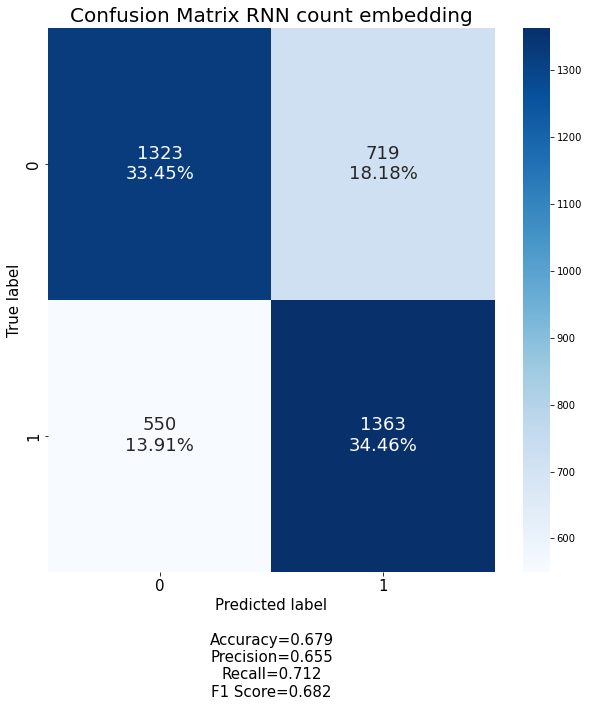

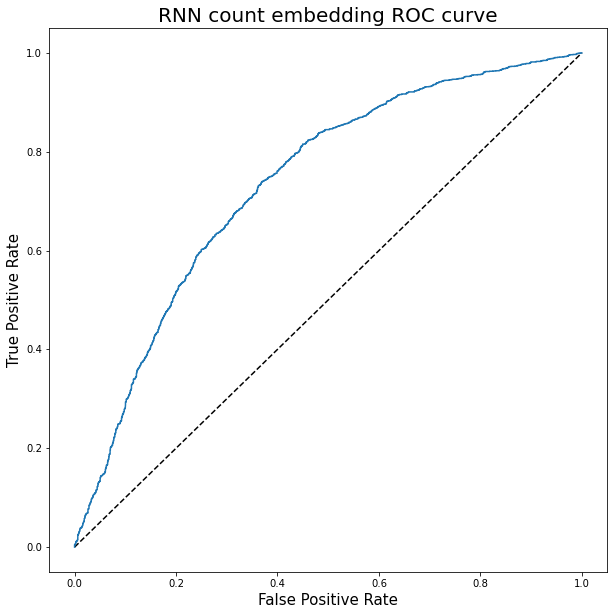

In [274]:
y_test_pred_proba_rnn = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_rnn = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_rnn]

print(classification_report(y_test, y_test_pred_rnn))

model_title = 'RNN count embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_rnn), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_rnn)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### RNN on word counting vector on w2v with embedding layer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)

vocabulary_size_w2v = embedding_matrix_w2v.shape[0]
results_data_path = os.path.join("results")
model_name = "rnn_on_embedded_w2v"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = vocabulary_size_w2v

# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 25

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_w2v], input_length=100, trainable=False)

    # define NN model
    model = Sequential(name=model_name)
    

    # Embedding layer
    model.add(embedding_layer)
    model.add(Dropout(0.5))
    #model.add(Flatten())
    # RNN layer
    model.add(SimpleRNN(units=rnn_units, dropout=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation="relu"))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/10


2022-09-16 12:33:26.430016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.5085

2022-09-16 12:36:35.442693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 197s 2s/step - loss: 0.6930 - accuracy: 0.5085 - val_loss: 0.6928 - val_accuracy: 0.5326
Epoch 2/10
99/99 [==============================] - 199s 2s/step - loss: 0.6928 - accuracy: 0.5112 - val_loss: 0.6926 - val_accuracy: 0.4877
Epoch 3/10
99/99 [==============================] - 201s 2s/step - loss: 0.6911 - accuracy: 0.5320 - val_loss: 0.6916 - val_accuracy: 0.4867
Epoch 4/10
99/99 [==============================] - 206s 2s/step - loss: 0.6878 - accuracy: 0.5507 - val_loss: 0.6873 - val_accuracy: 0.5250
Epoch 5/10
99/99 [==============================] - 204s 2s/step - loss: 0.6834 - accuracy: 0.5593 - val_loss: 0.6862 - val_accuracy: 0.5351
Epoch 6/10
99/99 [==============================] - 206s 2s/step - loss: 0.6809 - accuracy: 0.5686 - val_loss: 0.6783 - val_accuracy: 0.5733
Epoch 7/10
99/99 [==============================] - 206s 2s/step - loss: 0.6773 - accuracy: 0.5700 - val_loss: 0.6713 - val_accuracy: 0.5942
Epoch 8/10
99/99 [======

In [ ]:
y_test_pred_proba_rnn = model.predict(
    X_test_w2v,
    batch_size=128
)

y_test_pred_rnn = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_rnn]

print(classification_report(y_test, y_test_pred_rnn))

model_title = 'RNN w2v embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_rnn), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_rnn)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

#### LSTM

##### LSTM and Convolutional Neural Network for Sequence Classification on word counting vector with embedding layer

In [34]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "lstm_on_embedded"
model_file_path = os.path.join(results_data_path, model_name)

# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM layer
    model.add(LSTM(units=rnn_units, dropout=0.2))
    
    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.2))
    #model.add(Dense(25, activation="relu"))
    #model.add(Dropout(0.2))
    #model.add(Dense(10, activation="relu"))
    #model.add(Dropout(0.2))
    
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

2022-09-16 13:51:55.753378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-16 13:51:57.125149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 13:51:57.127890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 13:51:57.285663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 13:51:57.640355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 13:51:57.798016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.5466

2022-09-16 13:52:02.031230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 13:52:02.096723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 6s 40ms/step - loss: 0.6754 - accuracy: 0.5466 - val_loss: 0.5789 - val_accuracy: 0.6982
Epoch 2/10
99/99 [==============================] - 2s 23ms/step - loss: 0.5042 - accuracy: 0.7649 - val_loss: 0.5667 - val_accuracy: 0.7222
Epoch 3/10
99/99 [==============================] - 2s 21ms/step - loss: 0.3556 - accuracy: 0.8546 - val_loss: 0.6966 - val_accuracy: 0.7114
Epoch 4/10
99/99 [==============================] - 2s 20ms/step - loss: 0.2437 - accuracy: 0.9079 - val_loss: 0.7510 - val_accuracy: 0.7073


INFO:tensorflow:Assets written to: results/lstm_on_embedded/assets


Model: "lstm_on_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_9 (TextV  (None, 30)               0         
 ectorization)                                                   
                                                                 
 embedding_9 (Embedding)     (None, 30, 100)           1000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 32)            9632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0         
 )                                                               
                                                                 
 lstm_9 (LSTM)               (None, 100)               53200     
                                                                 
 dense_15 (Dense)            (None, 25)           

10/31 [========>.....................] - ETA: 0s

2022-09-16 13:52:18.087781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 13:52:18.148460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      2042
           1       0.68      0.77      0.72      1913

    accuracy                           0.71      3955
   macro avg       0.72      0.71      0.71      3955
weighted avg       0.72      0.71      0.71      3955



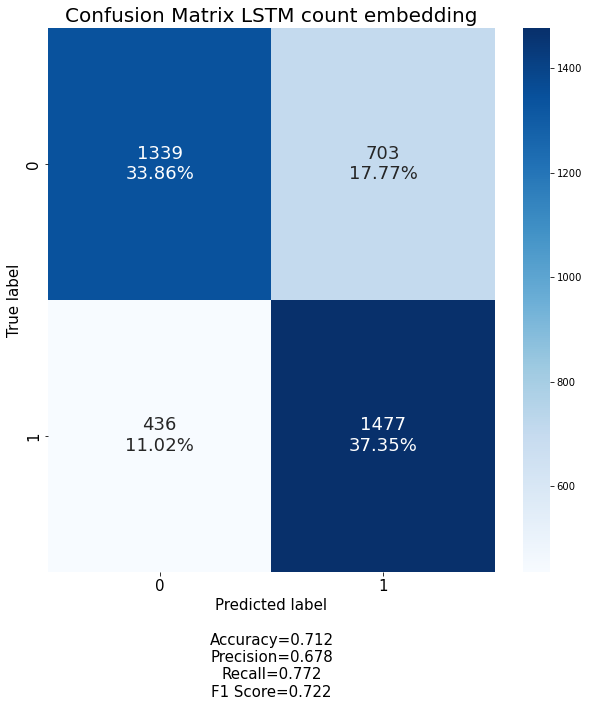

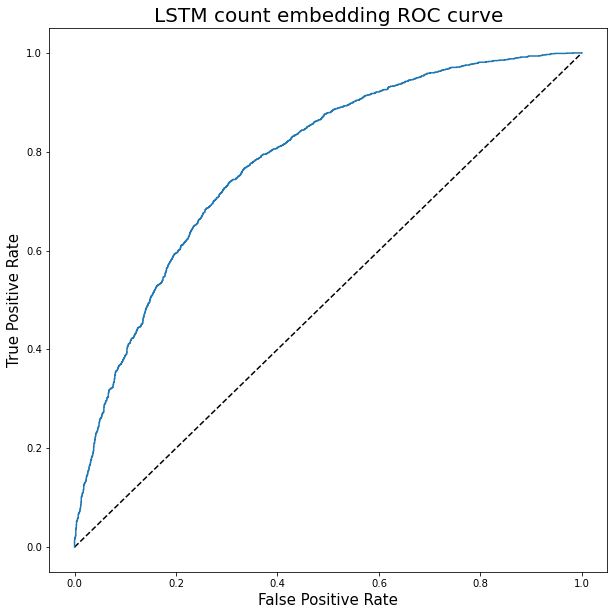

In [35]:
y_test_pred_proba_lstm = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_lstm = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_lstm]

print(classification_report(y_test, y_test_pred_lstm))

model_title = 'LSTM count embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_lstm), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lstm)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### LSTM and Convolutional Neural Network for Sequence Classification on w2v with embedding layer

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "lstm_w2v_embedded"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = embedding_matrix_w2v.shape[0]
# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    
    # define NN model
    model = Sequential(name=model_name)
    
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_w2v], input_length=100, trainable=False)
    model.add(embedding_layer)
    
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # LSTM layer
    model.add(LSTM(units=rnn_units, dropout=0.2))
    
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20


2022-09-16 14:01:37.871134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:01:38.038854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:01:38.273536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6929 - accuracy: 0.5115

2022-09-16 14:01:41.044889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:01:41.107173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 4s 29ms/step - loss: 0.6929 - accuracy: 0.5115 - val_loss: 0.6917 - val_accuracy: 0.5079
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6788 - accuracy: 0.5819 - val_loss: 0.6602 - val_accuracy: 0.6166
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6484 - accuracy: 0.6291 - val_loss: 0.6443 - val_accuracy: 0.6217
Epoch 4/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6299 - accuracy: 0.6490 - val_loss: 0.6343 - val_accuracy: 0.6324
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6167 - accuracy: 0.6619 - val_loss: 0.6297 - val_accuracy: 0.6372
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.6084 - accuracy: 0.6689 - val_loss: 0.6234 - val_accuracy: 0.6448
Epoch 7/20
99/99 [==============================] - 2s 20ms/step - loss: 0.6178 - accuracy: 0.6627 - val_loss: 0.6194 - val_accuracy: 0.6485
Epoch 8/20
99/99 [======

INFO:tensorflow:Assets written to: results/lstm_w2v_embedded/assets


Model: "lstm_w2v_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 100)          1413900   
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 32)           9632      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, 100)               53200     
                                                                 
 dense_21 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1,476,833
Trainable params: 62,933
Non-trainable params: 1,413,900
__________________________________

 1/31 [..............................] - ETA: 9s

2022-09-16 14:02:26.741643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:02:26.804125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 11ms/step
              precision    recall  f1-score   support

           0       0.80      0.50      0.62      2042
           1       0.62      0.87      0.72      1913

    accuracy                           0.68      3955
   macro avg       0.71      0.69      0.67      3955
weighted avg       0.71      0.68      0.67      3955



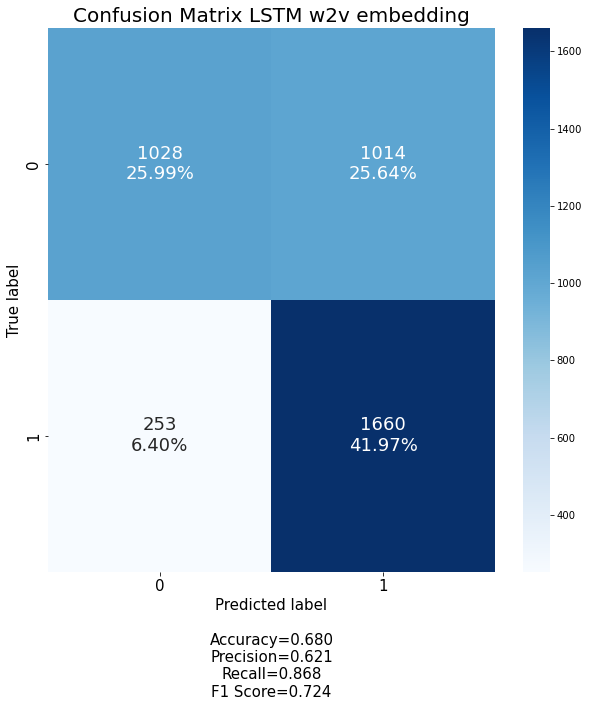

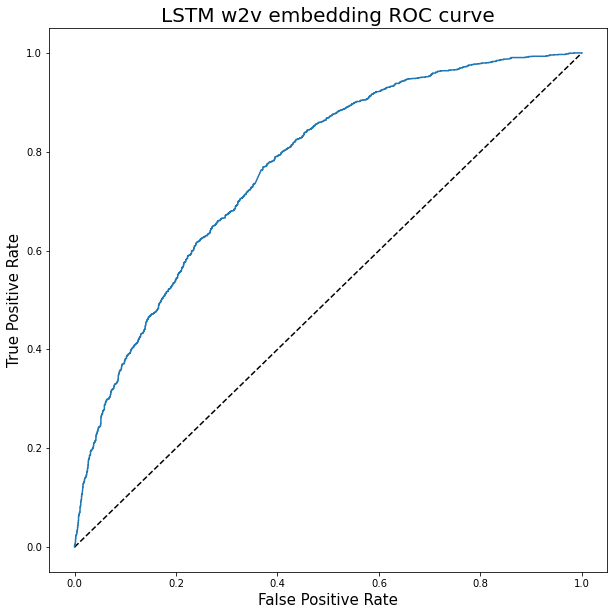

In [43]:
y_test_pred_proba_lstm = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_lstm = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_lstm]

print(classification_report(y_test, y_test_pred_lstm))

model_title = 'LSTM w2v embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_lstm), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lstm)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### LSTM and Convolutional Neural Network for Sequence Classification on glove with embedding layer

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_glove, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "lstm_glove_embedded"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = embedding_matrix_glove.shape[0]
# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    
    # define NN model
    model = Sequential(name=model_name)
    
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_glove], input_length=100, trainable=False)
    model.add(embedding_layer)
    
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))
    
    # LSTM layer
    model.add(LSTM(units=rnn_units, dropout=0.2))
    
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=20,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/20


2022-09-16 14:07:42.306522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:07:42.453322: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:07:42.692989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.6283

2022-09-16 14:07:46.981605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:07:47.037392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 6s 44ms/step - loss: 0.6403 - accuracy: 0.6283 - val_loss: 0.6128 - val_accuracy: 0.6710
Epoch 2/20
99/99 [==============================] - 3s 32ms/step - loss: 0.6044 - accuracy: 0.6706 - val_loss: 0.5973 - val_accuracy: 0.6839
Epoch 3/20
99/99 [==============================] - 3s 32ms/step - loss: 0.5901 - accuracy: 0.6795 - val_loss: 0.5876 - val_accuracy: 0.6909
Epoch 4/20
99/99 [==============================] - 3s 33ms/step - loss: 0.5815 - accuracy: 0.6877 - val_loss: 0.5861 - val_accuracy: 0.6881
Epoch 5/20
99/99 [==============================] - 3s 32ms/step - loss: 0.5703 - accuracy: 0.6957 - val_loss: 0.5837 - val_accuracy: 0.6890
Epoch 6/20
99/99 [==============================] - 3s 32ms/step - loss: 0.5600 - accuracy: 0.7076 - val_loss: 0.5815 - val_accuracy: 0.6884
Epoch 7/20
99/99 [==============================] - 3s 32ms/step - loss: 0.5470 - accuracy: 0.7165 - val_loss: 0.5804 - val_accuracy: 0.6925
Epoch 8/20
99/99 [======

INFO:tensorflow:Assets written to: results/lstm_glove_embedded/assets


Model: "lstm_glove_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          1413900   
                                                                 
 lstm_14 (LSTM)              (None, 100)               80400     
                                                                 
 dense_23 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1,494,401
Trainable params: 80,501
Non-trainable params: 1,413,900
_________________________________________________________________
None


2022-09-16 14:08:29.197181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:08:29.246545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.73      0.65      0.69      2042
           1       0.67      0.74      0.70      1913

    accuracy                           0.70      3955
   macro avg       0.70      0.70      0.70      3955
weighted avg       0.70      0.70      0.70      3955



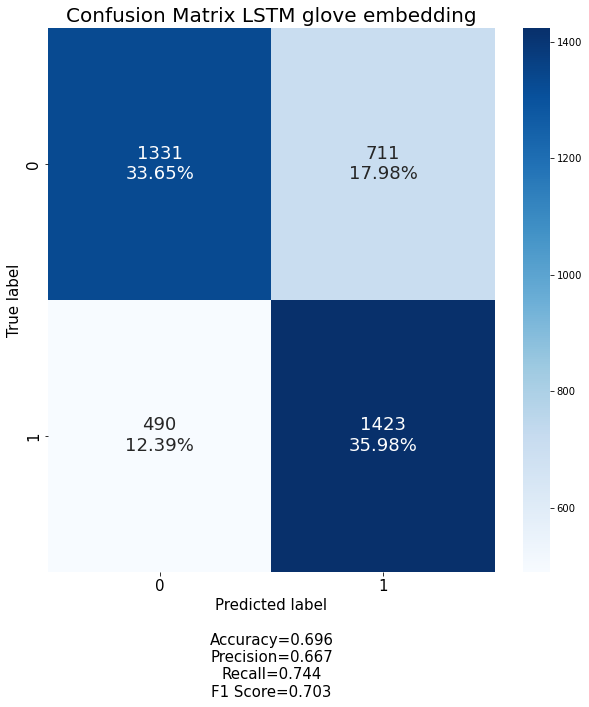

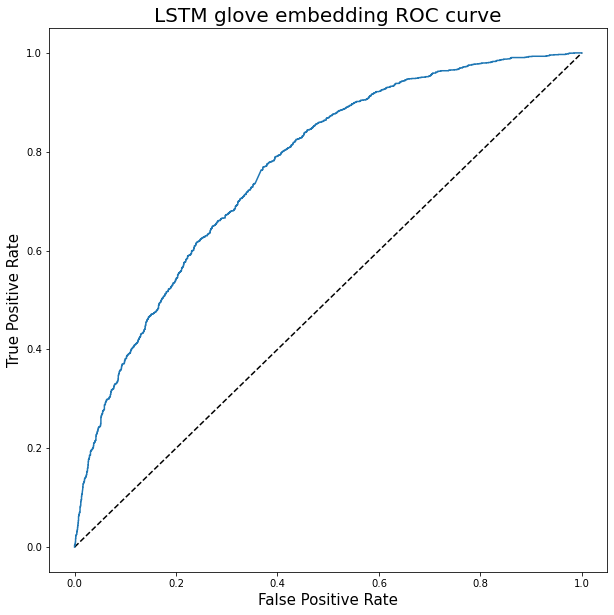

In [50]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

print(classification_report(y_test, y_test_pred))

model_title = 'LSTM glove embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_lstm)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

#### Bidirectional LSTM
##### Bidirectional LSTM on word counting vector

In [61]:
X_train, X_test, y_train, y_test = train_test_split(data.CleanText, data.Target, train_size = 0.8, random_state = 1)

results_data_path = os.path.join("results")
model_name = "bidirectional_lstm_on_embedded"
model_file_path = os.path.join(results_data_path, model_name)

# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100


if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    # Define vectorizer
    vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
    vectorize_layer.adapt(
        data.CleanText,
        batch_size=128,
    )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)

    # Embedding layer
    model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )
    
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.5))

    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ]
    )

    model.save(model_file_path)


print(model.summary())

2022-09-16 14:18:46.209926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2022-09-16 14:18:48.367576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:18:48.677245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:18:48.687235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:18:48.961693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:18:48.977463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6552 - accuracy: 0.5969

2022-09-16 14:18:54.557424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:18:54.663023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:18:54.671855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 9s 58ms/step - loss: 0.6552 - accuracy: 0.5969 - val_loss: 0.5593 - val_accuracy: 0.7067
Epoch 2/10
99/99 [==============================] - 4s 38ms/step - loss: 0.4806 - accuracy: 0.7824 - val_loss: 0.5641 - val_accuracy: 0.7200
Epoch 3/10
99/99 [==============================] - 3s 32ms/step - loss: 0.3505 - accuracy: 0.8562 - val_loss: 0.6398 - val_accuracy: 0.7070


INFO:tensorflow:Assets written to: results/bidirectional_lstm_on_embedded/assets


Model: "bidirectional_lstm_on_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_15 (Text  (None, 30)               0         
 Vectorization)                                                  
                                                                 
 embedding_21 (Embedding)    (None, 30, 100)           1000000   
                                                                 
 conv1d_9 (Conv1D)           (None, 30, 32)            9632      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 15, 32)           0         
 1D)                                                             
                                                                 
 bidirectional_5 (Bidirectio  (None, 200)              106400    
 nal)                                                            
                                    

2022-09-16 14:19:13.739706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:19:13.839311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:19:13.851008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      2042
           1       0.69      0.74      0.71      1913

    accuracy                           0.71      3955
   macro avg       0.71      0.71      0.71      3955
weighted avg       0.71      0.71      0.71      3955



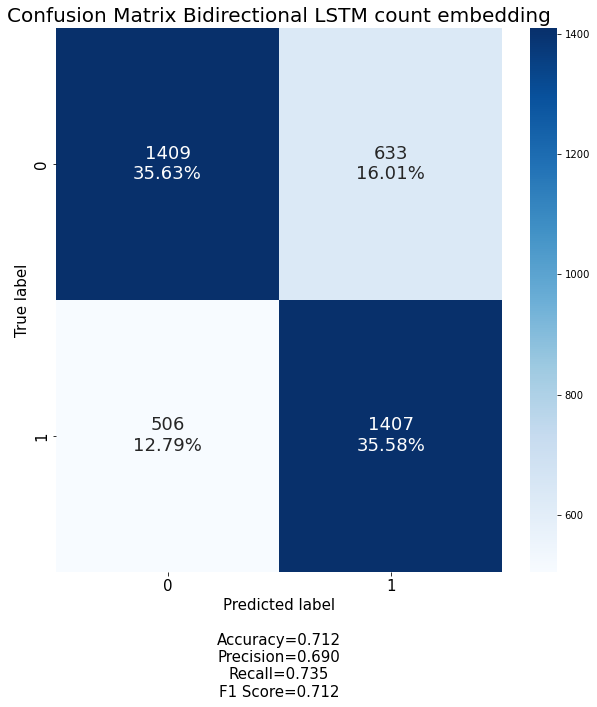

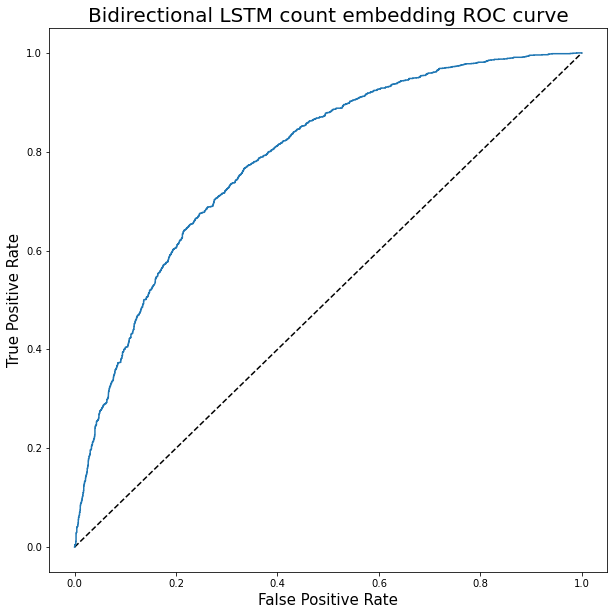

In [62]:
y_test_pred_proba_blstm = model.predict(
    X_test,
    batch_size=128
)

y_test_pred_blstm = [round(pred_proba[0]) for pred_proba in y_test_pred_proba_blstm]

print(classification_report(y_test, y_test_pred_blstm))
model_title = 'Bidirectional LSTM count embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred_blstm), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba_blstm)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### Bidirectional LSTM on Word2Vec

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "blstm_w2v_embedded"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = embedding_matrix_w2v.shape[0]
# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    
    # define NN model
    model = Sequential(name=model_name)
    
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_w2v], input_length=100, trainable=False)
    model.add(embedding_layer)
    
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.5))


    
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/30


2022-09-16 14:31:28.693688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:31:28.973611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:31:28.986369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:31:29.441955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:31:29.456516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5101

2022-09-16 14:31:37.454337: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:31:37.545326: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:31:37.553614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 11s 81ms/step - loss: 0.6931 - accuracy: 0.5101 - val_loss: 0.6933 - val_accuracy: 0.4836
Epoch 2/30
99/99 [==============================] - 6s 63ms/step - loss: 0.6928 - accuracy: 0.5094 - val_loss: 0.6927 - val_accuracy: 0.4848
Epoch 3/30
99/99 [==============================] - 6s 59ms/step - loss: 0.6910 - accuracy: 0.5335 - val_loss: 0.6902 - val_accuracy: 0.5259
Epoch 4/30
99/99 [==============================] - 6s 59ms/step - loss: 0.6845 - accuracy: 0.5590 - val_loss: 0.6730 - val_accuracy: 0.5857
Epoch 5/30
99/99 [==============================] - 6s 59ms/step - loss: 0.6729 - accuracy: 0.5881 - val_loss: 0.6686 - val_accuracy: 0.5923
Epoch 6/30
99/99 [==============================] - 6s 59ms/step - loss: 0.6669 - accuracy: 0.5985 - val_loss: 0.6629 - val_accuracy: 0.6056
Epoch 7/30
99/99 [==============================] - 6s 60ms/step - loss: 0.6636 - accuracy: 0.6039 - val_loss: 0.6618 - val_accuracy: 0.6125
Epoch 8/30
99/99 [=====

INFO:tensorflow:Assets written to: results/blstm_w2v_embedded/assets


Model: "blstm_w2v_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 100, 100)          1413900   
                                                                 
 bidirectional_10 (Bidirecti  (None, 200)              160800    
 onal)                                                           
                                                                 
 dense_45 (Dense)            (None, 25)                5025      
                                                                 
 dropout_20 (Dropout)        (None, 25)                0         
                                                                 
 dense_46 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,579,751
Trainable params: 165,851
Non-trainable params: 1,413,900
________________________________

2022-09-16 14:32:46.916451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:32:46.996555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:32:47.006869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      2042
           1       0.69      0.74      0.71      1913

    accuracy                           0.71      3955
   macro avg       0.71      0.71      0.71      3955
weighted avg       0.71      0.71      0.71      3955



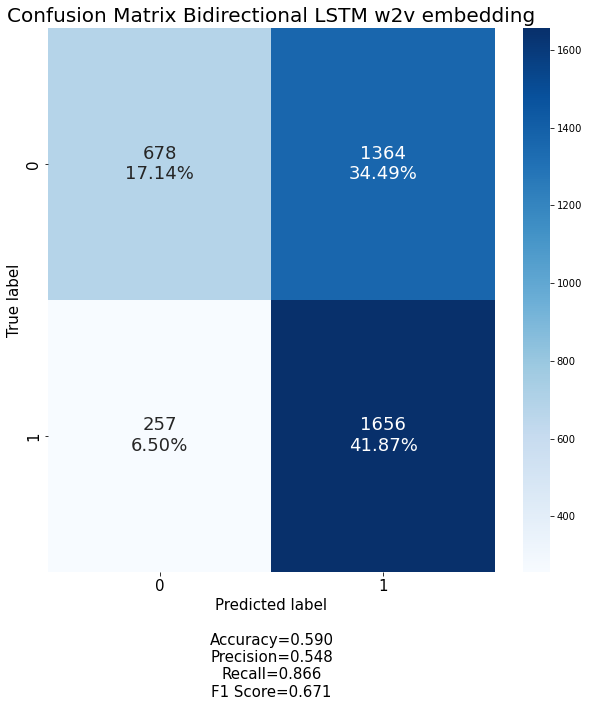

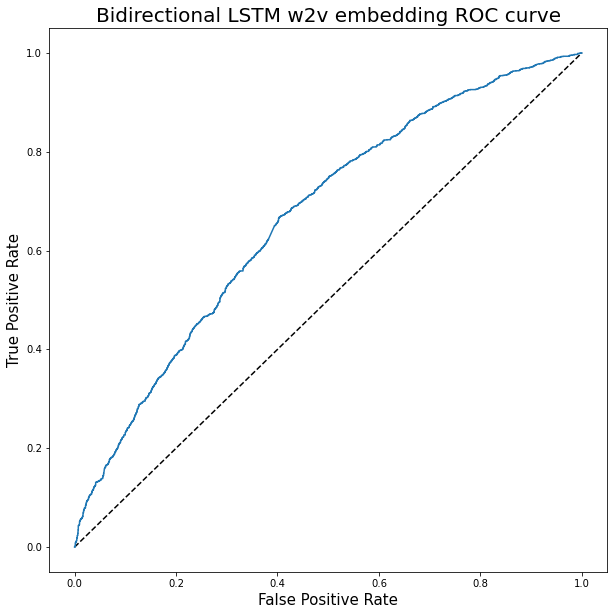

In [71]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

print(classification_report(y_test, y_test_pred_blstm))
model_title = 'Bidirectional LSTM w2v embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

##### Bidirectional LSTM on Glove

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, data.Target, train_size = 0.8, random_state = 1)


results_data_path = os.path.join("results")
model_name = "blstm_glove_embedded"
model_file_path = os.path.join(results_data_path, model_name)
vocab_size = embedding_matrix_glove.shape[0]
# Model constants.
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

if os.path.exists(model_file_path):
    # Load model
    model = load_model(model_file_path)
else:
    
    # define NN model
    model = Sequential(name=model_name)
    
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix_glove], input_length=100, trainable=False)
    model.add(embedding_layer)
    
    #model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    #model.add(MaxPooling1D(pool_size=2))

    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

    # Dense layers
    model.add(Dense(25, input_shape=(max_features,), activation="relu"))
    model.add(Dropout(0.5))


    
    # Classification layer
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy"
        ],
    )

    # fit NN model
    model.fit(
        X_train,
        y_train,
        epochs=30,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            TensorBoard(log_dir=f"logs/{model.name}"),
            EarlyStopping(monitor="val_loss", patience=2),
        ],
    )

    model.save(model_file_path)


print(model.summary())

Epoch 1/30


2022-09-16 14:36:41.620687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:36:41.971742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:36:41.985745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:36:42.519896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:36:42.534454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.6142

2022-09-16 14:36:49.982548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:36:50.077197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:36:50.085937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


99/99 [==============================] - 11s 81ms/step - loss: 0.6518 - accuracy: 0.6142 - val_loss: 0.6188 - val_accuracy: 0.6564
Epoch 2/30
99/99 [==============================] - 6s 59ms/step - loss: 0.6172 - accuracy: 0.6610 - val_loss: 0.6077 - val_accuracy: 0.6691
Epoch 3/30
99/99 [==============================] - 6s 59ms/step - loss: 0.6036 - accuracy: 0.6702 - val_loss: 0.6057 - val_accuracy: 0.6618
Epoch 4/30
99/99 [==============================] - 6s 58ms/step - loss: 0.5937 - accuracy: 0.6828 - val_loss: 0.5876 - val_accuracy: 0.6846
Epoch 5/30
99/99 [==============================] - 6s 59ms/step - loss: 0.5853 - accuracy: 0.6888 - val_loss: 0.5826 - val_accuracy: 0.6963
Epoch 6/30
99/99 [==============================] - 6s 58ms/step - loss: 0.5742 - accuracy: 0.7011 - val_loss: 0.5783 - val_accuracy: 0.6988
Epoch 7/30
99/99 [==============================] - 6s 59ms/step - loss: 0.5670 - accuracy: 0.7003 - val_loss: 0.5819 - val_accuracy: 0.6896
Epoch 8/30
99/99 [=====

INFO:tensorflow:Assets written to: results/blstm_glove_embedded/assets


Model: "blstm_glove_embedded"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 100, 100)          1413900   
                                                                 
 bidirectional_12 (Bidirecti  (None, 200)              160800    
 onal)                                                           
                                                                 
 dense_49 (Dense)            (None, 25)                5025      
                                                                 
 dropout_22 (Dropout)        (None, 25)                0         
                                                                 
 dense_50 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,579,751
Trainable params: 165,851
Non-trainable params: 1,413,900
______________________________

2022-09-16 14:37:57.831597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:37:57.915813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-09-16 14:37:57.926633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

           0       0.74      0.69      0.71      2042
           1       0.69      0.74      0.71      1913

    accuracy                           0.71      3955
   macro avg       0.71      0.71      0.71      3955
weighted avg       0.71      0.71      0.71      3955



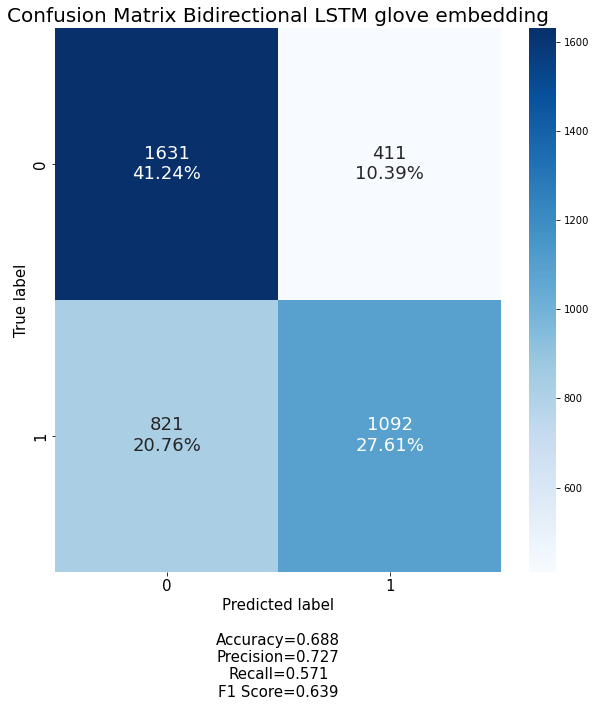

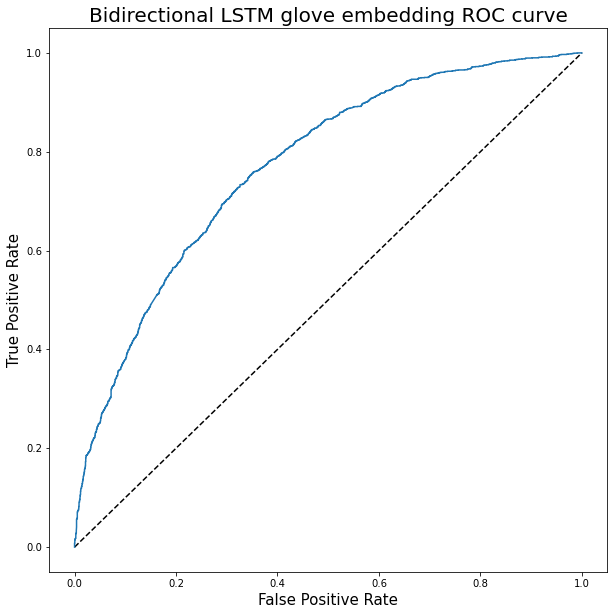

In [75]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

print(classification_report(y_test, y_test_pred_blstm))
model_title = 'Bidirectional LSTM glove embedding'
accuracy, precision, recall, f1_score = make_confusion_matrix(confusion_matrix(y_test, y_test_pred), figsize=(10, 10), title='Confusion Matrix {0}'.format(model_title))
# performing the roc curve calculations
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
# Plotting the ROC Curve
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LR')
plt.xlabel('False Positive Rate', size=15)
plt.ylabel('True Positive Rate', size=15)
plt.title('{0} ROC curve'.format(model_title), size=20)
plt.show()

## Advanced BERT model